# 1 Setup

In this notebook, I will build ML models to predict whether a person will get a loan. I will also perform credit grade and subgrade forecasting.

In [ ]:
!pip install pywaffle
!pip install missingno
!pip install optuna
!pip install shap
!pip install category_encoders

In [ ]:
# Data analysis and calculation
import pandas as pd
import numpy as np
from calendar import month_abbr
from google.colab import drive
from additional_functions import *

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pywaffle import Waffle
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import RFECV
from yellowbrick.style import set_palette

plt.rcParams["figure.dpi"] = 200
import missingno as msno

# Machine learning prediction
import joblib
import optuna
import shap
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.feature_selection import RFECV


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# neural networks
import torch
import torch.nn as nn

# Warnings handling and import
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

drive.mount("/content/drive")

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


Mounted at /content/drive


In [ ]:
path = "accepted_2007_to_2018Q4.csv"
accepted_loan_df = pd.read_csv(path)

path = "rejected_2007_to_2018Q4.csv"
rejected_loan_df = pd.read_csv(path)

## 1.2 Accepted loan data

In [ ]:
Q1 = accepted_loan_df.quantile(0.1)
Q3 = accepted_loan_df.quantile(0.9)
IQR = Q3 - Q1

accepted_loan_df = accepted_loan_df[
    ~(
        (accepted_loan_df < (Q1 - 1.5 * IQR)) | (accepted_loan_df > (Q3 + 1.5 * IQR))
    ).any(axis=1)
]

We have plenty of **Nan** values so the first step will be to check if they are distributed randomly. I will study columns that contain a huge number of these values.

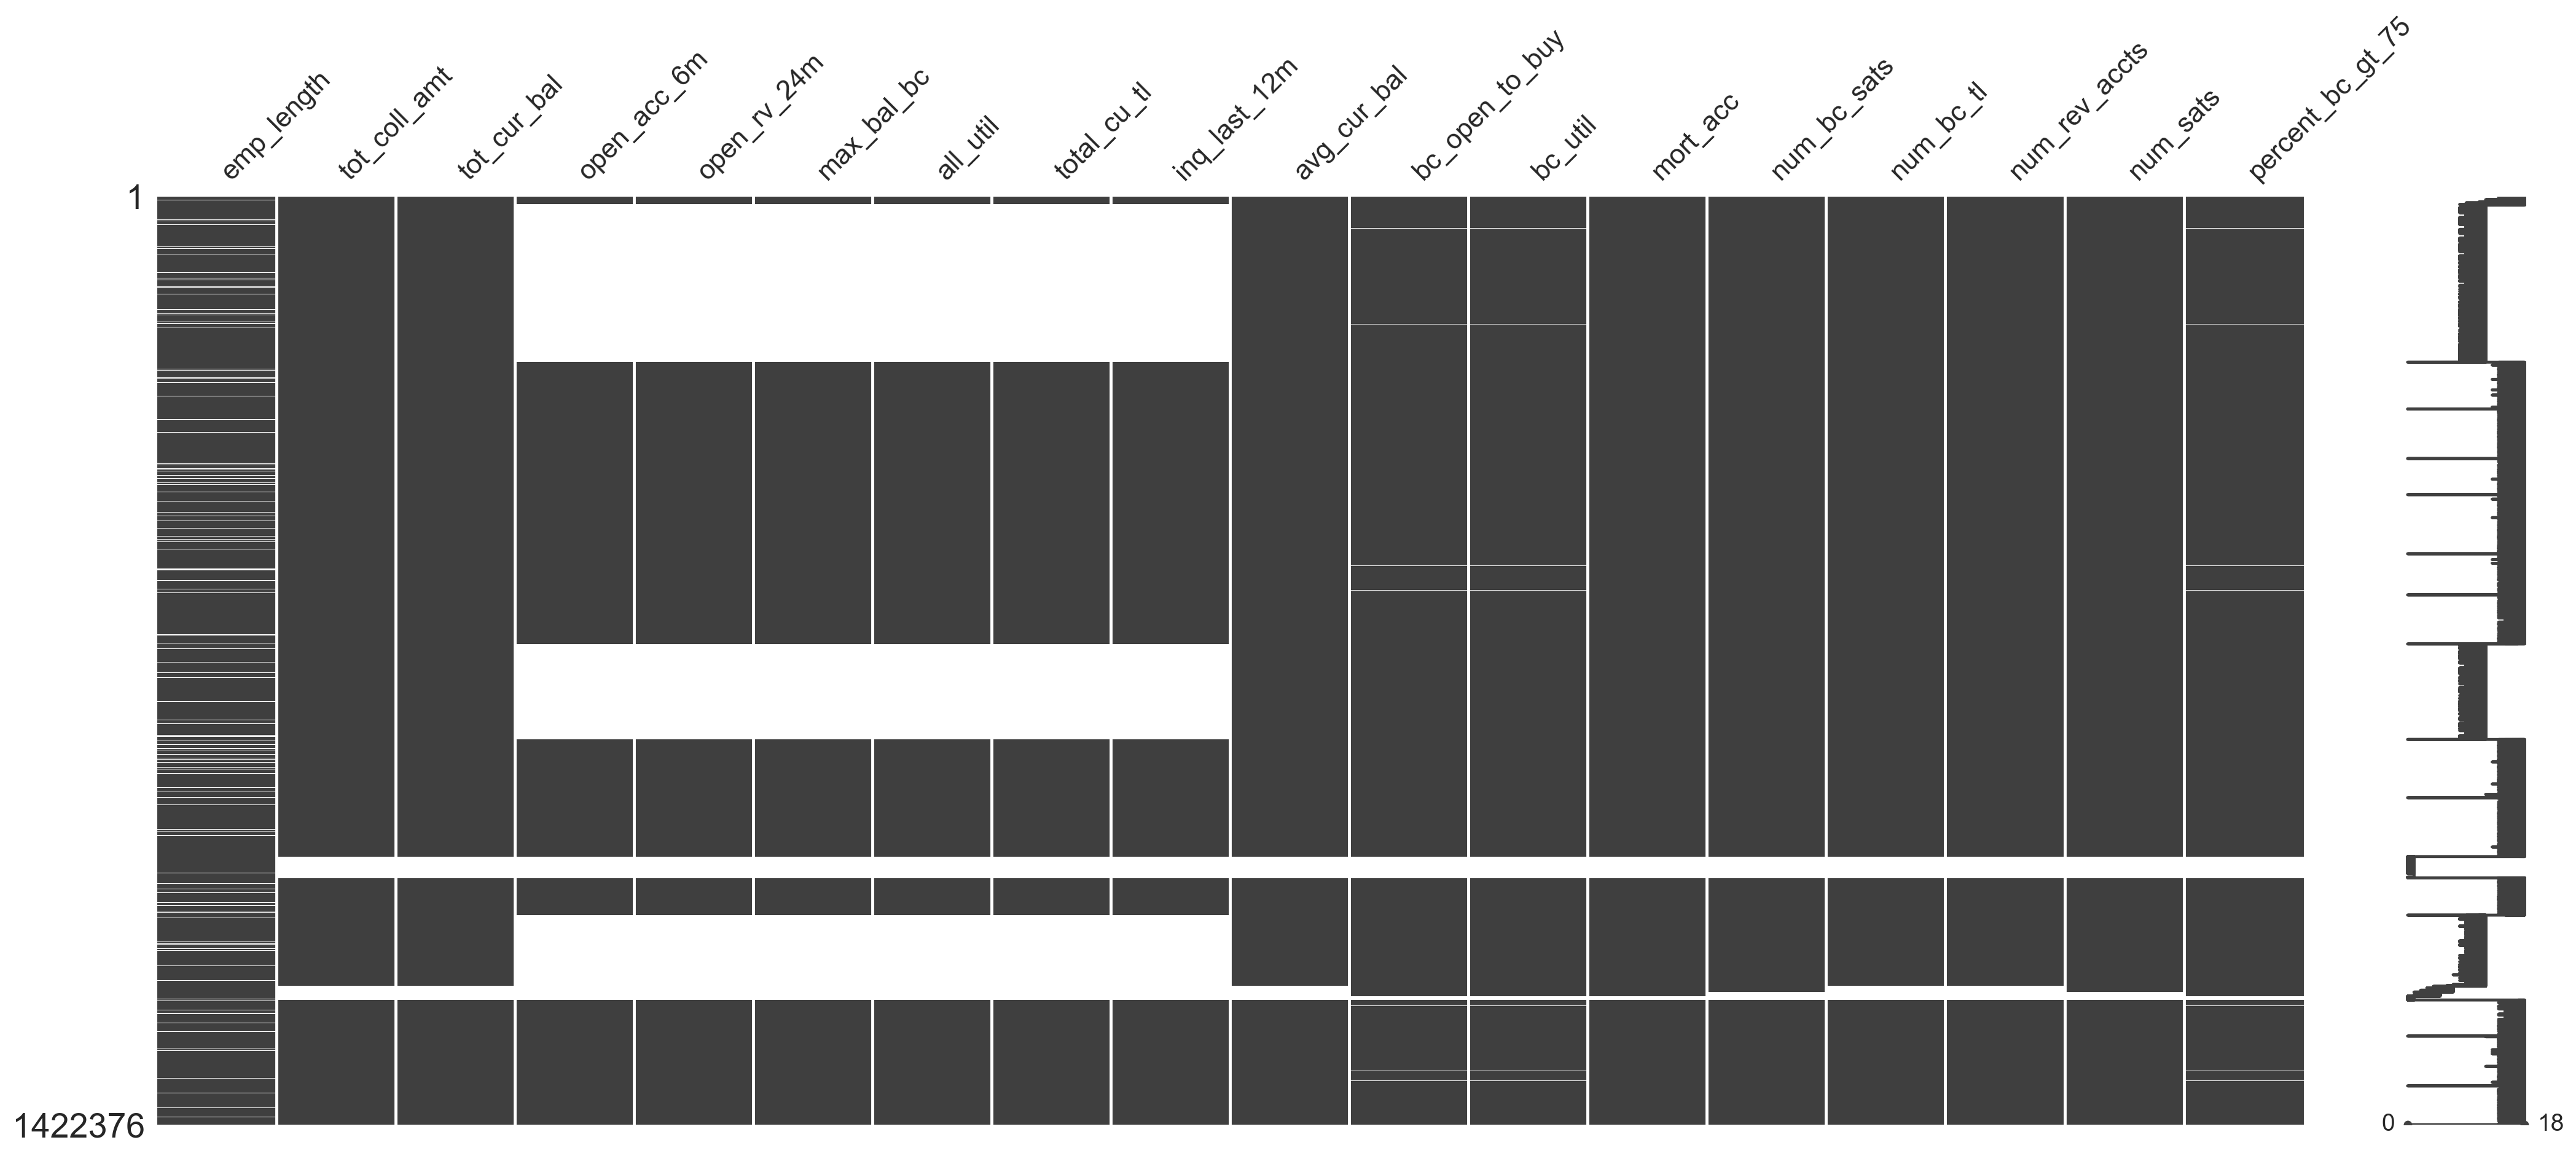

In [ ]:
msno.matrix(
    accepted_loan_df[
        [
            "emp_length",
            "tot_coll_amt",
            "tot_cur_bal",
            "open_acc_6m",
            "open_rv_24m",
            "max_bal_bc",
            "all_util",
            "total_cu_tl",
            "inq_last_12m",
            "avg_cur_bal",
            "bc_open_to_buy",
            "bc_util",
            "mort_acc",
            "num_bc_sats",
            "num_bc_tl",
            "num_rev_accts",
            "num_sats",
            "percent_bc_gt_75",
        ]
    ]
)

plt.show()

We see that there are only 3 columns with randomly distributed values of **Nan**. This dataset contains over 2 million rows, so it won't be a big loss if we get rid of this data. There are also no very effective ways to fill in the gaps in such a situation. For the first three columns, I will try to find the best way to fill in the missing values.

In [ ]:
accepted_loan_df = (
    accepted_loan_df.pipe(drop_null)
    .pipe(
        drop_spec,
        [
            "tot_coll_amt",
            "tot_cur_bal",
            "open_acc_6m",
            "open_rv_24m",
            "max_bal_bc",
            "all_util",
            "total_cu_tl",
            "inq_last_12m",
            "avg_cur_bal",
            "bc_open_to_buy",
            "bc_util",
            "mort_acc",
            "num_bc_sats",
            "num_bc_tl",
            "num_rev_accts",
            "num_sats",
            "percent_bc_gt_75",
        ],
    )
    .pipe(date_extract, "issue_d", "issue_year", "issue_month")
    .pipe(date_extract, "last_credit_pull_d", "last_credit_year", "last_credit_month")
    .pipe(median_two_columns, "fico_range_high", "fico_range_low", "fico_range")
    .pipe(
        median_two_columns,
        "last_fico_range_high",
        "last_fico_range_low",
        "last_fico_range",
    )
    .pipe(ys_column, "hardship_reason", "hardship_loan")
    .pipe(employment_acc, "emp_title")
    .pipe(replace_zero, ["hardship_amount", "annual_inc_joint", "dti_joint"])
    .pipe(replace_uknown, ["hardship_status"])
    .pipe(
        drop_columns,
        [
            "member_id",
            "url",
            "desc",
            "zip_code",
            "earliest_cr_line",
            "inq_last_6mths",
            "initial_list_status",
            "out_prncp",
            "out_prncp_inv",
            "total_pymnt_inv",
            "total_rec_prncp",
            "next_pymnt_d",
            "total_rec_late_fee",
            "mths_since_last_major_derog",
            "policy_code",
            "open_act_il",
            "open_il_12m",
            "open_rv_12m",
            "inq_fi",
            "acc_open_past_24mths",
            "mo_sin_old_il_acct",
            "mo_sin_old_rev_tl_op",
            "mo_sin_rcnt_tl",
            "num_actv_bc_tl",
            "num_tl_120dpd_2m",
            "num_tl_30dpd",
            "num_tl_90g_dpd_24m",
            "num_tl_op_past_12m",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "sec_app_earliest_cr_line",
            "sec_app_inq_last_6mths",
            "sec_app_mort_acc",
            "sec_app_open_acc",
            "sec_app_revol_util",
            "sec_app_open_act_il",
            "sec_app_num_rev_accts",
            "sec_app_chargeoff_within_12_mths",
            "sec_app_collections_12_mths_ex_med",
            "sec_app_mths_since_last_major_derog",
            "payment_plan_start_date",
            "orig_projected_additional_accrued_interest",
            "id",
            "hardship_type",
            "deferral_term",
            "hardship_start_date",
            "hardship_end_date",
            "disbursement_method",
            "debt_settlement_flag_date",
            "debt_settlement_flag",
            "settlement_status",
            "settlement_date",
            "settlement_status",
            "settlement_date",
            "settlement_amount",
            "settlement_percentage",
            "settlement_term",
            "fico_range_low",
            "fico_range_high",
            "last_fico_range_high",
            "last_fico_range_low",
            "hardship_flag",
            "hardship_reason",
            "hardship_length",
            "hardship_loan_status",
            "hardship_dpd",
            "hardship_last_payment_amount",
            "hardship_payoff_balance_amount",
            "pymnt_plan",
            "revol_bal_joint",
            "installment",
            "total_il_high_credit_limit",
            "total_bc_limit",
            "total_bal_ex_mort",
            "tot_hi_cred_lim",
            "pct_tl_nvr_dlq",
            "num_rev_tl_bal_gt_0",
            "num_op_rev_tl",
            "num_il_tl",
            "num_actv_rev_tl",
            "num_accts_ever_120_pd",
            "mths_since_recent_revol_delinq",
            "mths_since_recent_inq",
            "mths_since_recent_bc_dlq",
            "mths_since_recent_bc",
            "mo_sin_rcnt_rev_tl_op",
            "chargeoff_within_12_mths",
            "total_rev_hi_lim",
            "mths_since_rcnt_il",
            "open_il_24m",
            "last_pymnt_amnt",
            "last_pymnt_d",
            "collection_recovery_fee",
            "total_pymnt",
            "installment",
            "loan_status",
            "collections_12_mths_ex_med",
            "title",
            "verification_status",
            "total_rec_int",
            "verification_status_joint",
            "total_bal_il",
            "il_util",
            "issue_d",
            "last_credit_pull_d",
            "mths_since_last_record",
            "mths_since_last_delinq",
        ],
    )
    .pipe(replace_int, "dti", 0, 100, 100)
    .pipe(cat_to_int, ["term"])
    .pipe(status, 1)
)

Actions done:
* All **Nan** were removed from columns which contained small amount of them
* Removed **Nan** from columns without random distribution
* Extracted years and month from string
* Connected two columns by their median, since both of them were skewed
* Replaced values with **0** and **1**
* Created employment groups
* Replaced missing values with **0** and **Unknown**
* Removed columns that display data that could not have been received before the issue date of the loan. In other words, we cannot use this data to build our model
* Replaced **categorical** data with **Int**

## 1.3 Rejected loan data

In [ ]:
Q1 = rejected_loan_df.quantile(0.1)
Q3 = rejected_loan_df.quantile(0.9)
IQR = Q3 - Q1

rejected_loan_df = rejected_loan_df[
    ~(
        (rejected_loan_df < (Q1 - 1.5 * IQR)) | (rejected_loan_df > (Q3 + 1.5 * IQR))
    ).any(axis=1)
]

We also need for to check for null values in this data set.

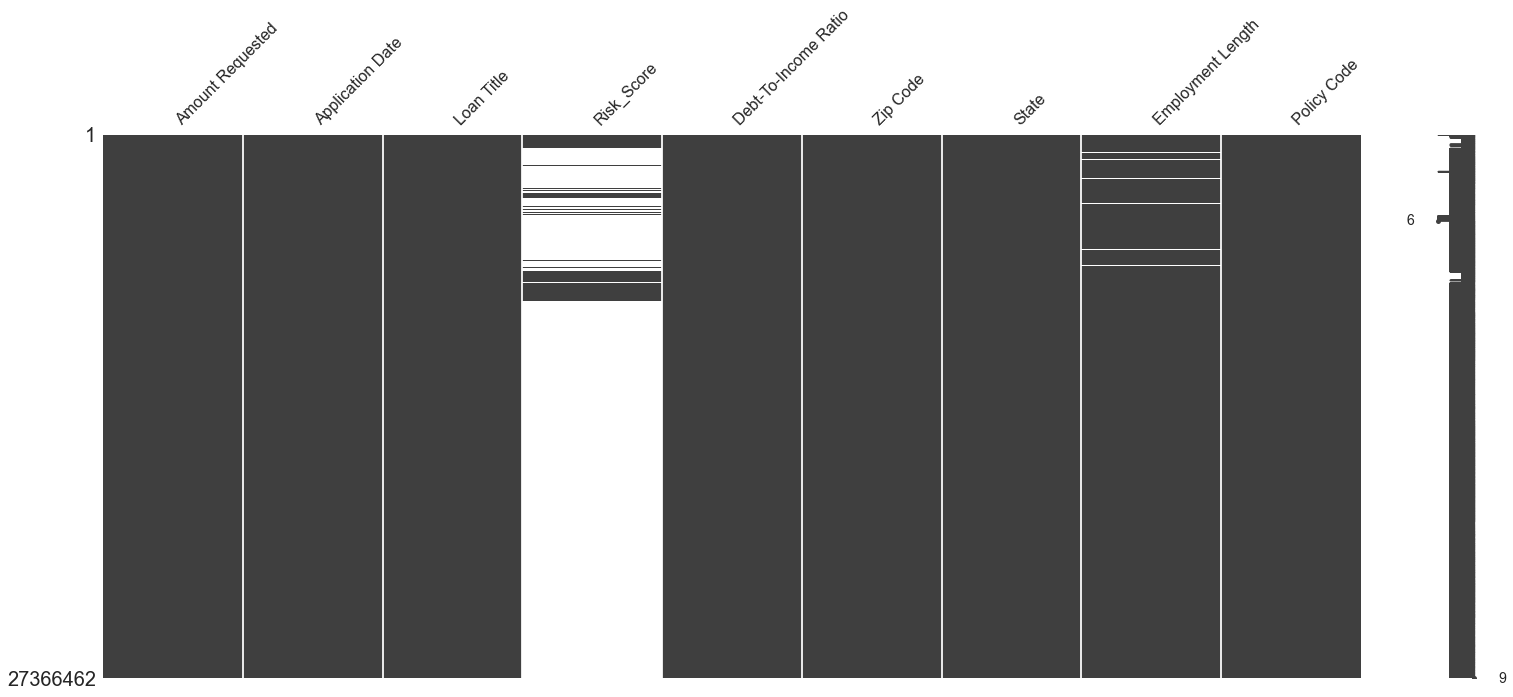

In [ ]:
msno.matrix(rejected_loan_df)

plt.show()

There are a huge number of missing values in the **Risk Score** column. They are also not randomly distributed, so there is only one correct solution - to drop them.

In [ ]:
rejected_loan_df = (
    rejected_loan_df.pipe(drop_null)
    .pipe(drop_spec, ["Employment Length", "Risk_Score"])
    .pipe(loan_reason, "Loan Title")
    .pipe(rejected_date_separate, "Application Date", "issue_month", "issue_year")
    .pipe(cat_to_int, ["Debt-To-Income Ratio"])
    .pipe(drop_columns, ["Zip Code", "Application Date", "Policy Code"])
    .pipe(replace_int, "Debt-To-Income Ratio", 0, 100, 100)
    .pipe(status, 0)
    .pipe(rename_columns)
)
rejected_loan_df = rejected_loan_df[~(rejected_loan_df["fico_range"] < 300)]
rejected_loan_df = rejected_loan_df.sample(frac=0.225)

* A small number of null values have been removed
* Also null values were droped from specific columns
* Groups of loan types were formed based on the given categorical data
* The data was divided into months and years
* Certain columns have been deleted
* Added new column with status
* The columns have been renamed to combine them with **accepted data**
* Data of employment lenght has been converted to numeric
* Wrong fico values were removed
* There were 8 million rows due to limited computing power the data was sampled and only 2 million rows remained

In [ ]:
# accepted_loan_df.to_csv("accepted_ml.csv", encoding='utf-8')
# rejected_loan_df.to_csv("rejected_ml.csv", encoding='utf-8')

The pre-processed data has been saved

In [ ]:
accepted_loan_df = pd.read_csv("/content/drive/MyDrive/accepted_ml.csv")

rejected_loan_df = pd.read_csv("/content/drive/MyDrive/rejected_ml.csv")

# 2 Machine learning



## 2.1 Prediction the result of applying for a loan

In this part, I will build some baseline models, and then I will perform parameter tuning to predict whether person will get a loan.

### 2.1.1 Feature engineering

I started by preparing datasets and features for ML modeling. I combined both data sets, removed some unnecessary columns, and converted the months data to **Sin** and **Cos**.


In [ ]:
rejected_list = rejected_loan_df.columns.values.tolist()
accepted_loan = accepted_loan_df[rejected_list]
merged_df = pd.concat([rejected_loan_df, accepted_loan], axis=0)
merged_df = merged_df.sample(frac=1)

In [ ]:
merged_df = (
    merged_df.pipe(transformation_mnths, "issue_month")
    .pipe(drop_columns, ["Unnamed: 0", "issue_month"])
    .pipe(drop_spec, ["emp_length"])
)

In [ ]:
X = merged_df.drop(columns=["status"])
y = merged_df["status"]

In [ ]:
numeric_features = ["loan_amnt", "fico_range", "dti"]
onehot_features = ["purpose", "emp_length"]
binary_features = ["addr_state"]
all_numeric = [
    "loan_amnt",
    "fico_range",
    "dti",
    "issue_year",
    "sin_mnths",
    "cos_mnths",
    "loan_amnt_quadratic",
    "loan_amnt_cubic",
    "loan_amnt_log",
    "loan_amnt_root",
    "fico_range_quadratic",
    "fico_range_cubic",
    "fico_range_log",
    "fico_range_root",
    "dti_quadratic",
    "dti_cubic",
    "dti_log",
    "dti_root",
]

In [ ]:
onehot_transformer = Pipeline(
    steps=[("onehot_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer = Pipeline(
    steps=[("binary_encoder", ce.BinaryEncoder(cols=binary_features))]
)

numeric_transforner = Pipeline(steps=[("numeric_transforner", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        (
            "numeric_transforner",
            make_pipeline(CustomTransformer(numeric_features), StandardScaler()),
            numeric_features,
        ),
        ("onehot", onehot_transformer, onehot_features),
        ("binary", binary_transformer, binary_features),
    ]
)
final_pipeline = Pipeline([("preprocessor", preprocessor)])

### 2.1.2 Cross-validation of baseline models

After preparing the data, I will perform cross-validation for several selected models. And after that, I will select a few of them for further tuning of hyperparameters.


In [ ]:
base_df = base_line(X, y, numeric_scaler, preprocessor)
base_df

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
XGB classifier,0.947329,0.954677,0.947329,0.944655,0.945977,0.991249,377.697660
Random Forest,0.968611,0.972402,0.968611,0.965645,0.967110,0.995593,854.407154
Logistic regression,0.500000,0.702215,0.500000,0.351108,0.412530,0.393029,22.702828
LGBM classifier,0.977596,0.979865,0.977596,0.974457,0.976008,0.997591,73.810313


* The best-fitting time has a logistic regression, but all other indicators are the worst
* LGBM performed best and have a very short fitting time
* XGB and Random Forest performed a little worse, but the fitting time is huge.

### 2.1.3 LGBM hyperparameters tuning

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=42
)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: LGBM_objective(trial, X_train, y_train, final_pipeline)
study.optimize(func, n_trials=40, show_progress_bar=True)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
lgbm_loans = Pipeline(
    steps=[
        ("final_pipeline", final_pipeline),
        ("classifier", LGBMClassifier(**lgbm_params)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, lgbm_loans.predict(X_valid)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    200545
           1       0.89      1.00      0.94     78423

    accuracy                           0.97    278968
   macro avg       0.95      0.98      0.96    278968
weighted avg       0.97      0.97      0.97    278968



* For this classification task, I believe f1 will be the most significant indicator for us because positive and negative classes are equally important to us. We want to be sure that a person will not default after receiving a loan, and we also want to make a profit
* Despite the feature engineering, we see that the performance of the model does not change much

In [ ]:
# filename = 'loan_lgbm.sav'
# joblib.dump(lgbm_loans, filename)

['loan_lgbm.sav']

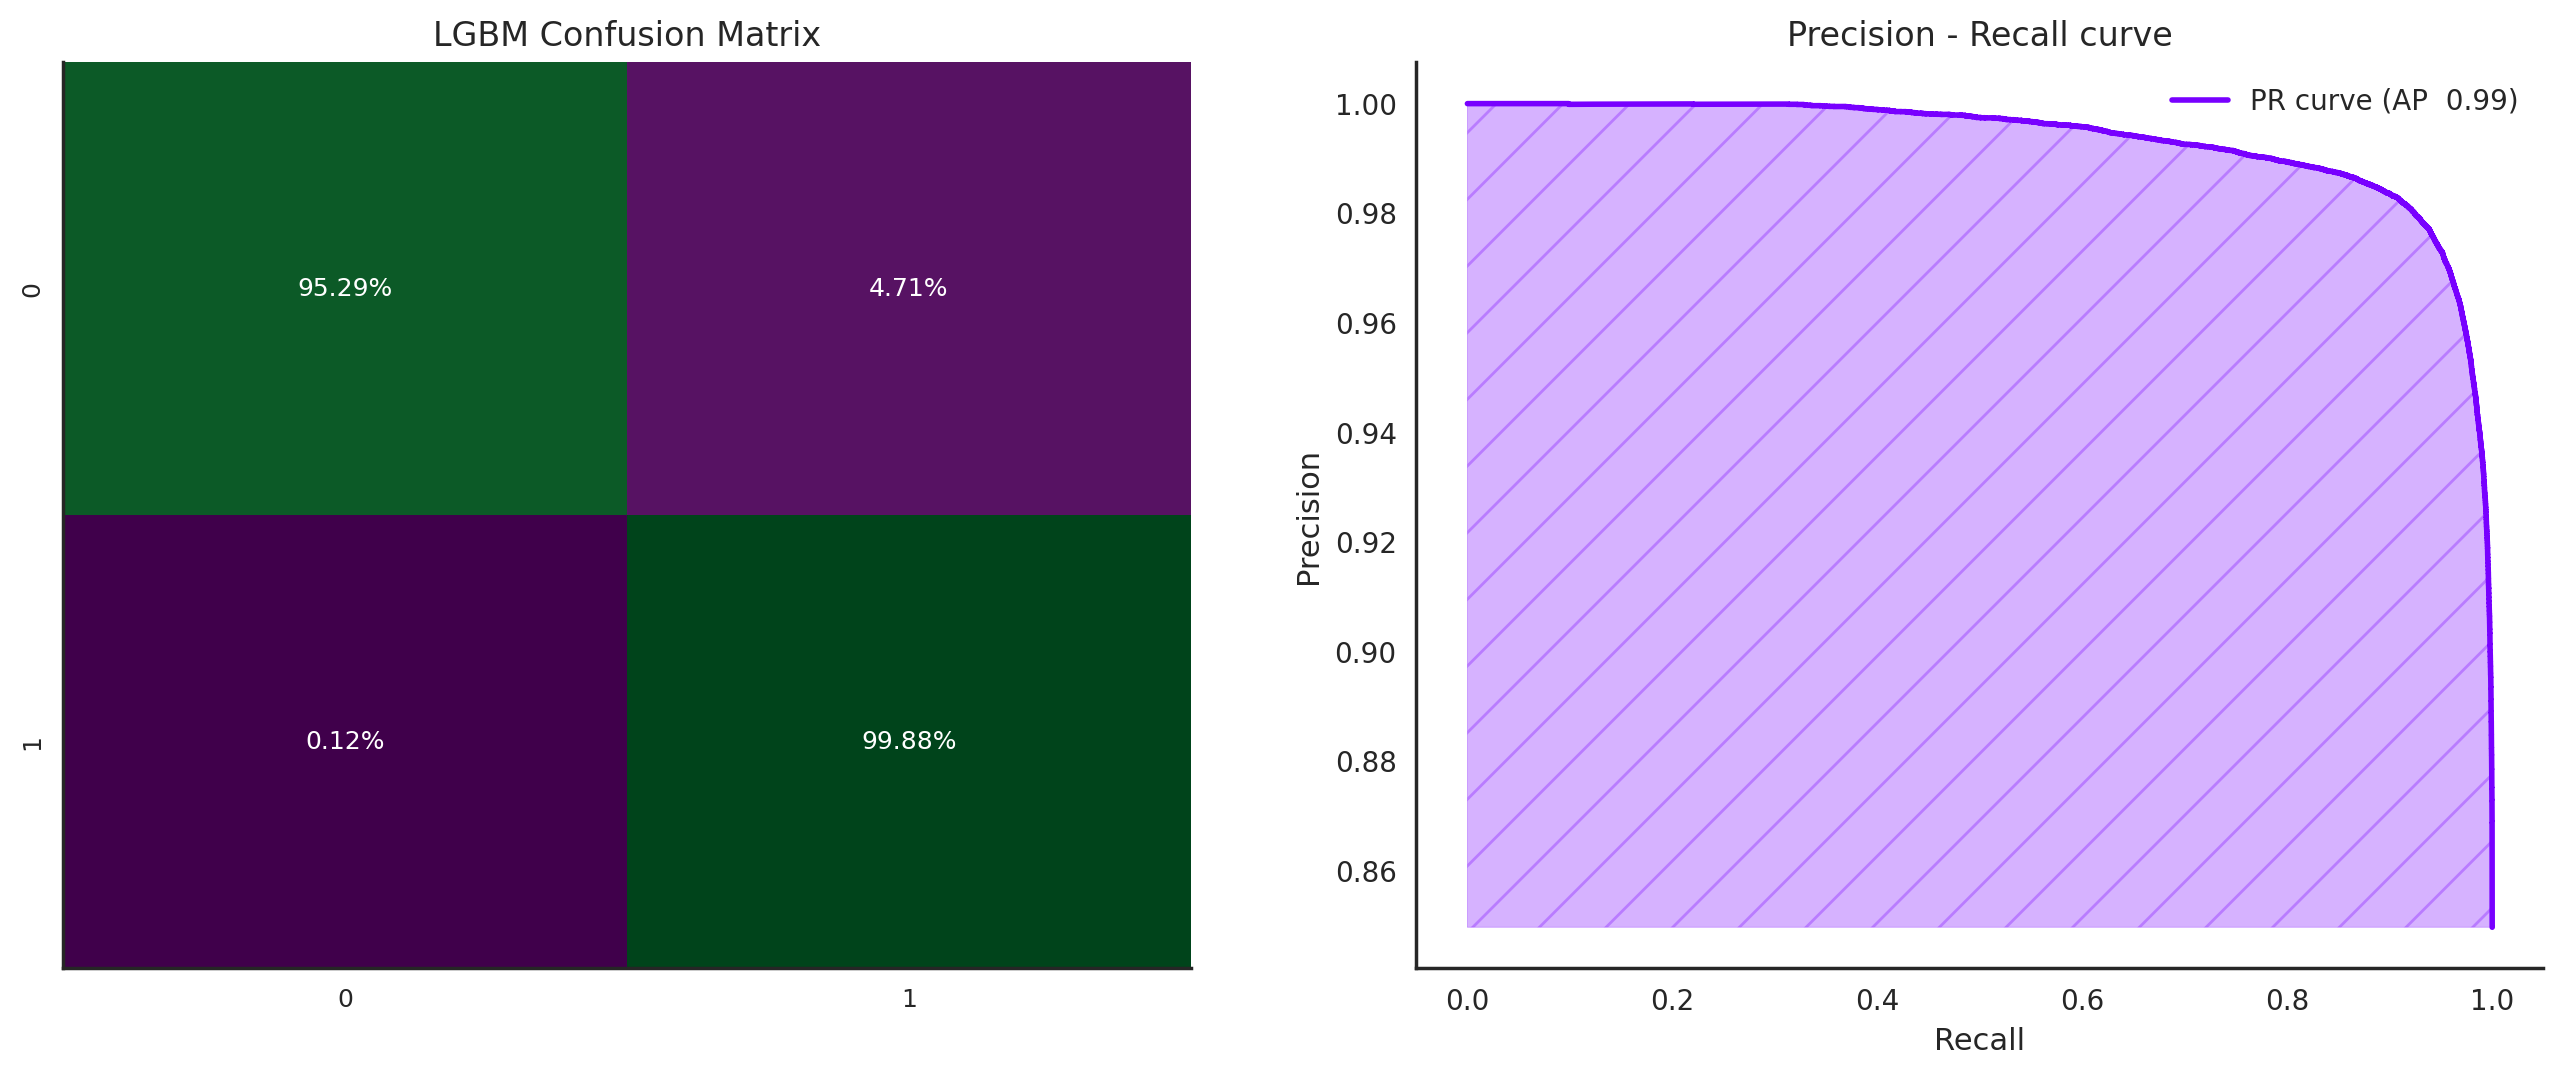

In [ ]:
conf_matrix(
    lgbm_loans, X_valid, y_valid, "LGBM Confusion Matrix", "Precision - Recall curve"
)

From the plot:

* There are more missclasifactions of 0 class compared to 1
* Since we have very unbalanced data, it is better to use **PR-AUC**. It demonstrates a very good balance between accuracy and recall for class 1. From the metric, we can conclude that it is almost perfect.

### 2.1.4 XGB hyperparameters tuning

Even though this model does not give better results compared to **Random Forest**, it reduces the fitting time. This is very important for us because, with such a large amount of data, the computational costs are quite high.

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGB Classifier")
func = lambda trial: xgboost_objective(trial, X_train, y_train, final_pipeline)
study.optimize(func, n_trials=25, show_progress_bar=True)

In [ ]:
trial = study.best_trial
xgb_params = trial.params

In [ ]:
xgb_loans = Pipeline(
    steps=[
        ("final_pipeline", final_pipeline),
        ("classifier", XGBClassifier(**xgb_params, tree_method="gpu_hist")),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, xgb_loans.predict(X_valid)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    199910
           1       0.80      1.00      0.89     84946

    accuracy                           0.93    284856
   macro avg       0.90      0.95      0.92    284856
weighted avg       0.94      0.93      0.93    284856



* We can see that after tuning the hyperparameters, the performance did not increase
* The model showed worse results in all respects compared to LGBM

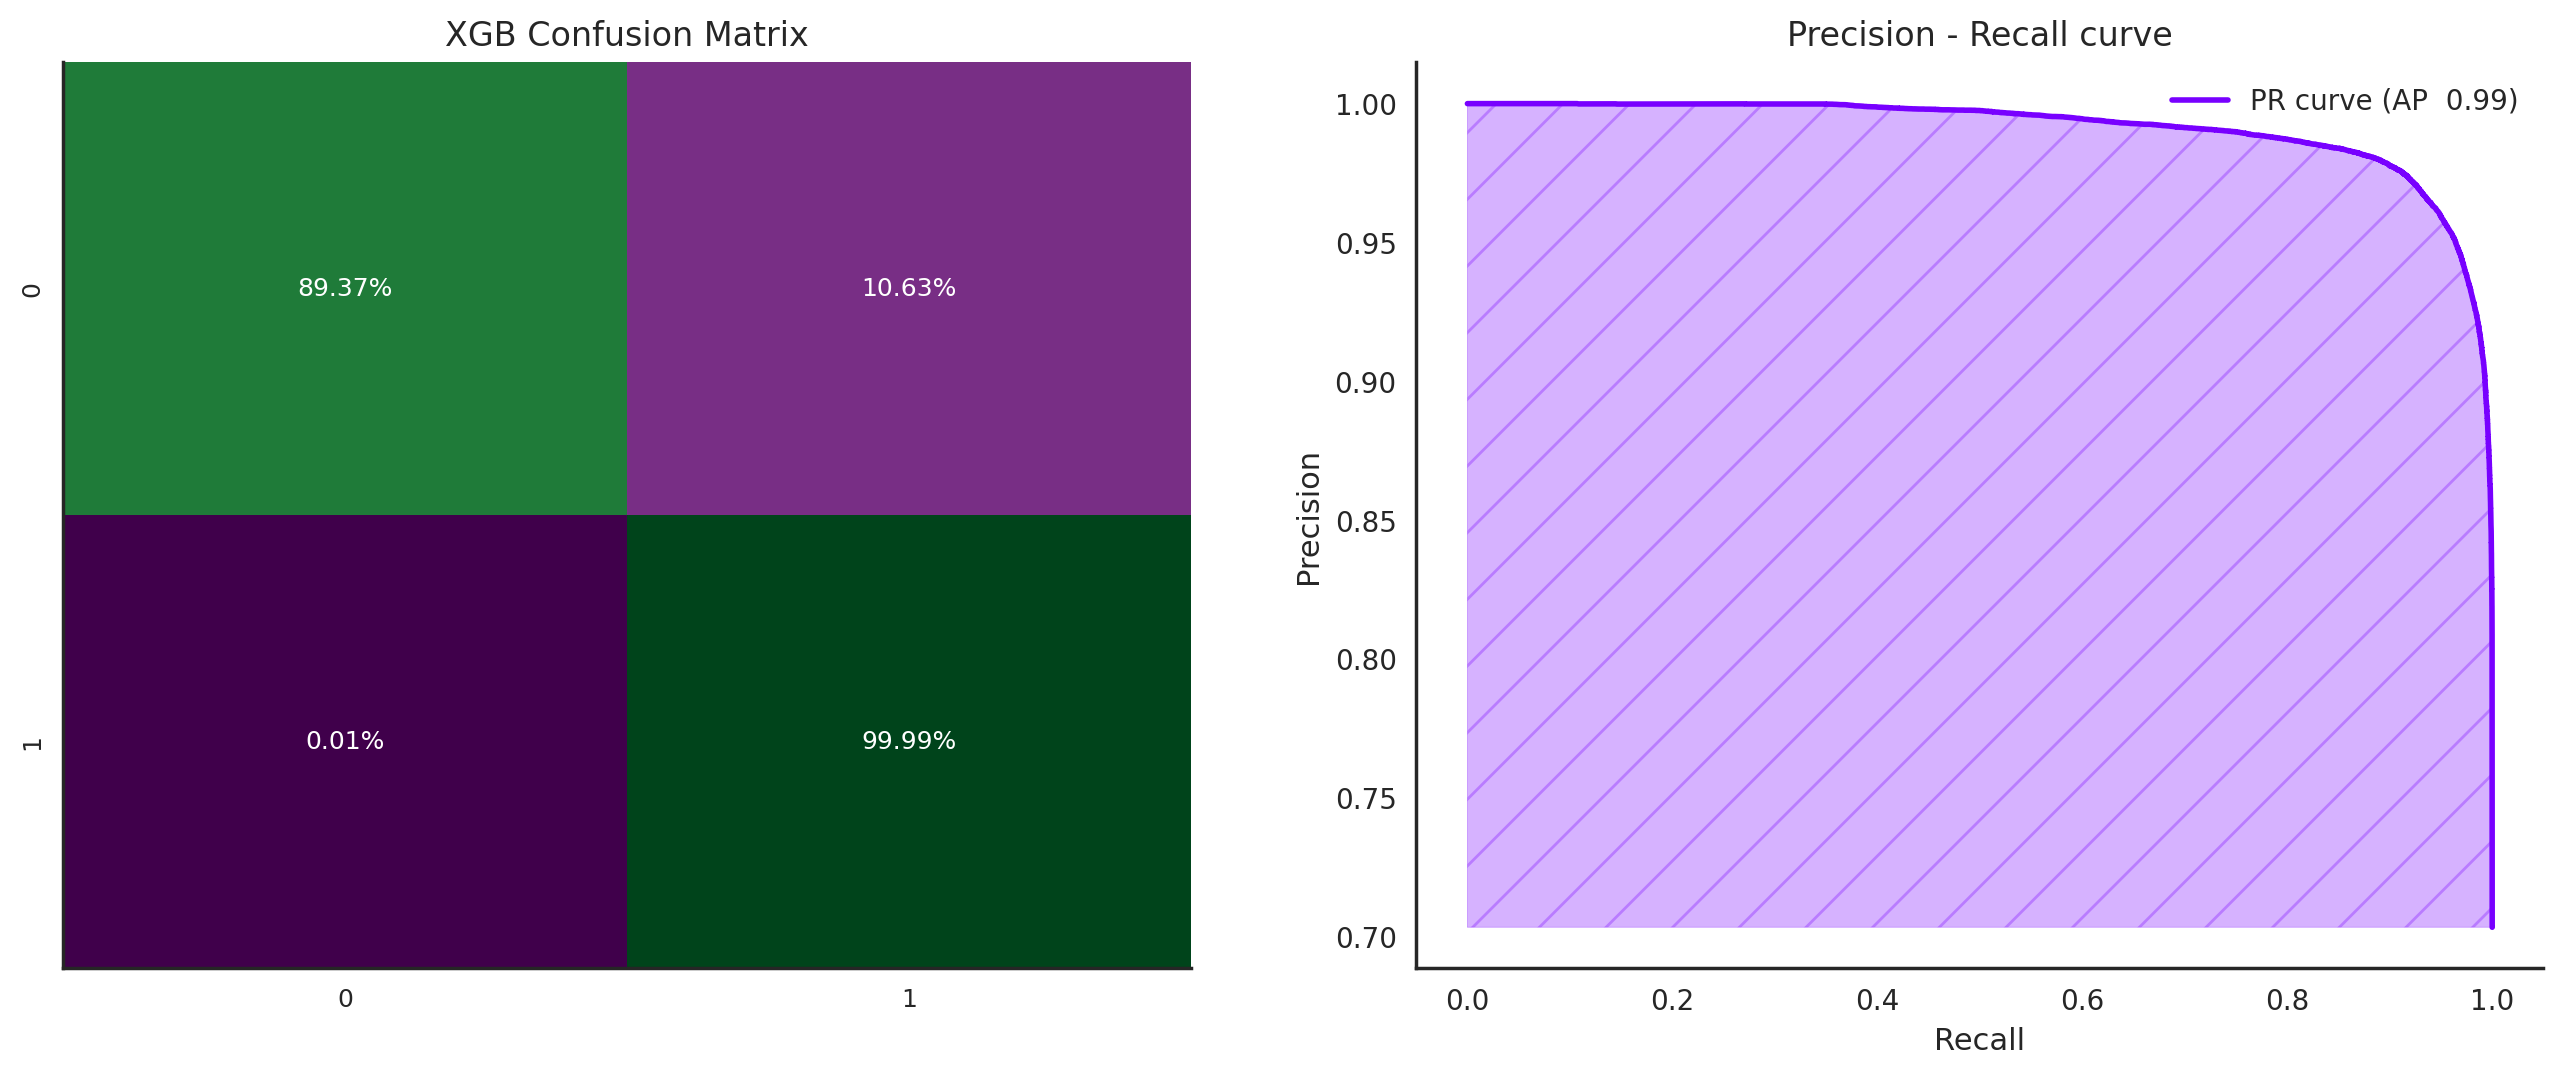

In [ ]:
conf_matrix(
    xgb_loans, X_valid, y_valid, "XGB Confusion Matrix", "Precision - Recall curve"
)

Insights:

* Compared to LGBM, it has fewer class 1 misclassifications, but at the same time more class 0 misclassifications
* PR-AUC curves are almost the same

### 2.1.5 LGBM feature importance

The LGBM model was chosen for deployment because it generally gives better results compared to others. The purpose of this part is to study this model a little better to understand which functions had the greatest impact on the result.

In [ ]:
data = list(get_feature_names(preprocessor))

Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [ ]:
X_test_tr = lgbm_loans[:-1].transform(X_test)
explainer = shap.TreeExplainer(lgbm_loans[-1])
shap_values = explainer.shap_values(X_test_tr)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


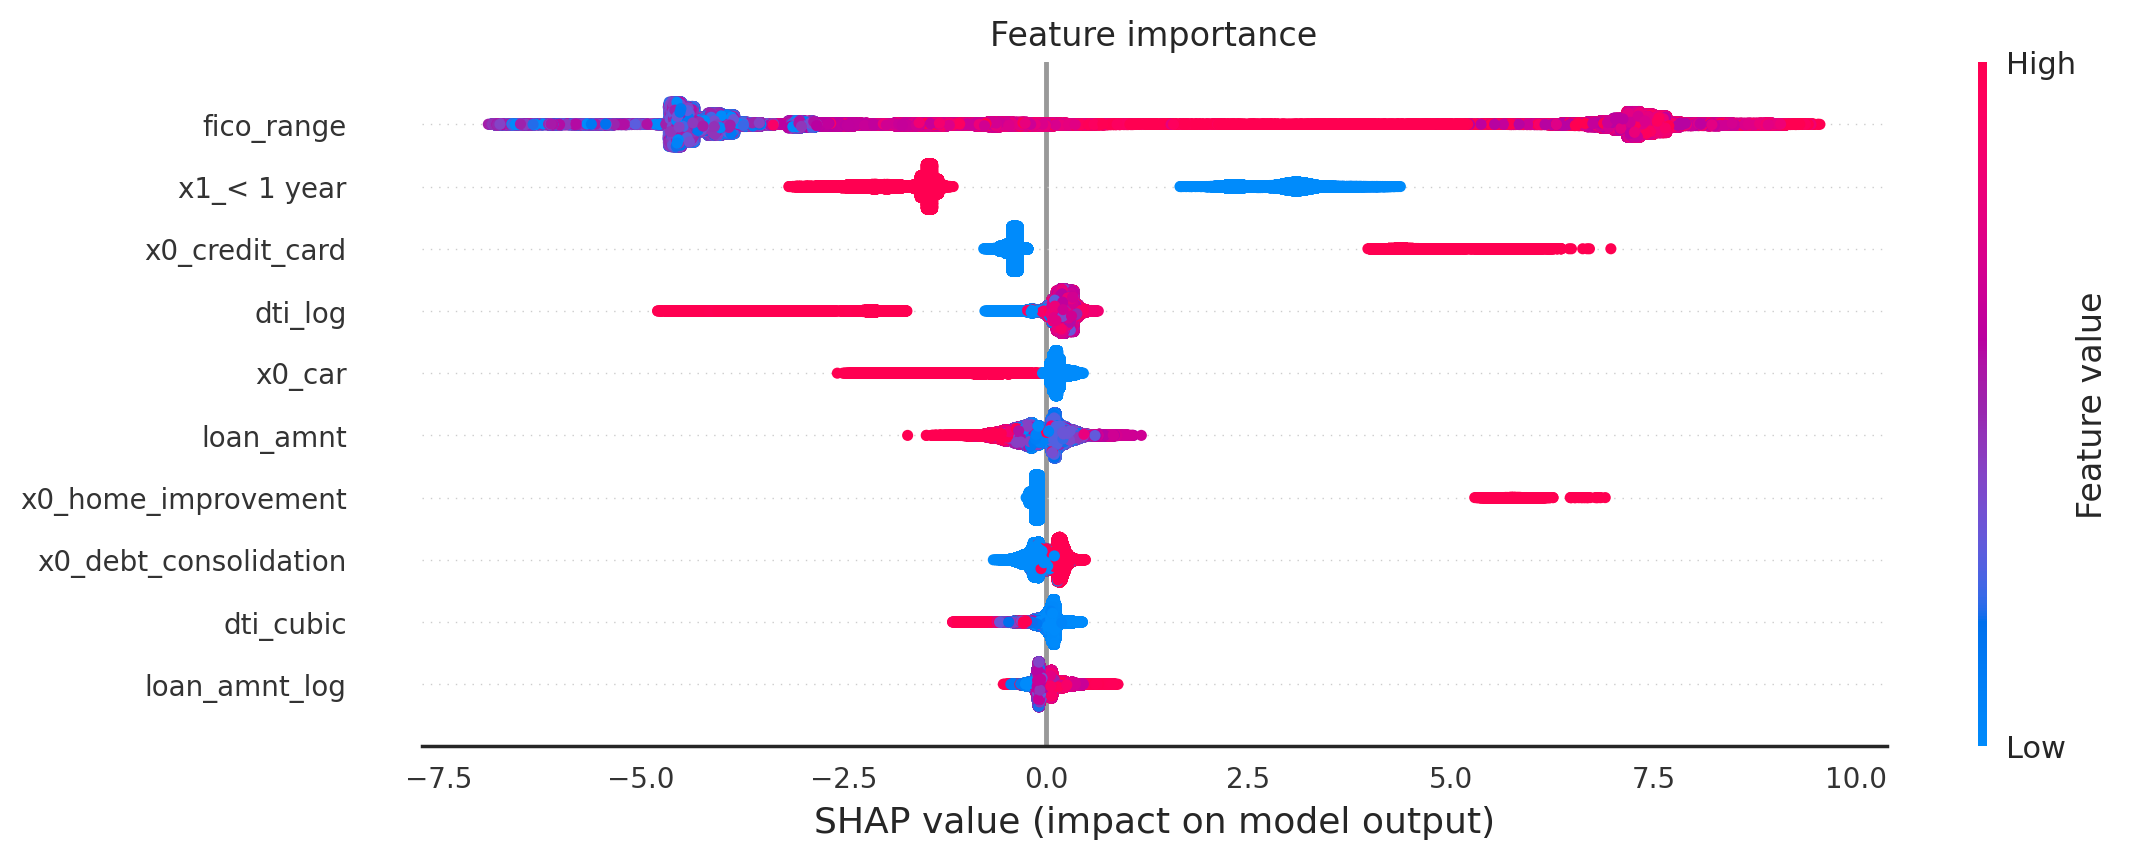

In [ ]:
shap.summary_plot(
    shap_values[1],
    X_test_tr,
    feature_names=data,
    max_display=10,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 4)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

Most important features are:

* **Fico Range**
* **Employment lenght equal to one year**
* **Purpose credit card**
* In addition, this output corresponds to the results of EDA

### 2.1.6 Misclassified values

In [ ]:
loan_pred = lgbm_loans.predict(X_test)

In [ ]:
misclassied_lgbm = X_test[(y_test == 1) & (loan_pred == 0)]

misclassied_lgbm.shape

(98, 9)

In [ ]:
misclassied_lgbm.sample(10)

,loan_amnt,purpose,fico_range,dti,addr_state,emp_length,issue_year,sin_mnths,cos_mnths
780669,35000.0,house,682.0,5.45,AL,< 1 year,2017,-8.660254e-01,5.000000e-01
102715,20000.0,debt_consolidation,687.0,48.88,NC,< 1 year,2017,-1.000000e+00,-1.836970e-16
193448,35000.0,debt_consolidation,667.0,41.54,NY,< 1 year,2016,8.660254e-01,-5.000000e-01
221479,25000.0,major_purchase,677.0,46.57,OH,< 1 year,2018,-1.000000e+00,-1.836970e-16
441671,5000.0,debt_consolidation,747.0,0.00,KY,< 1 year,2018,-2.449294e-16,1.000000e+00
456788,6000.0,other,662.0,55.93,OH,< 1 year,2018,-5.000000e-01,8.660254e-01
137052,22000.0,car,672.0,10.40,VA,< 1 year,2017,-5.000000e-01,-8.660254e-01
773369,10000.0,debt_consolidation,702.0,52.90,OK,< 1 year,2017,-8.660254e-01,5.000000e-01
463469,40000.0,other,662.0,5.31,PA,< 1 year,2018,-5.000000e-01,8.660254e-01
88308,10000.0,debt_consolidation,822.0,43.17,NJ,< 1 year,2017,-1.000000e+00,-1.836970e-16


* Despite the perfect fico and dti score, these data have been misclassified and I believe the main reason is the length of employment. 
* For the sake of research, it was discarded, and the classification result improved, but the overall performance decreased, so it was left as it is.

### 2.1.7 Model colibration

In this part, I will calibrate the probabilities and compare them with the non-calibrated model. This will help us understand if calibration is really necessary.

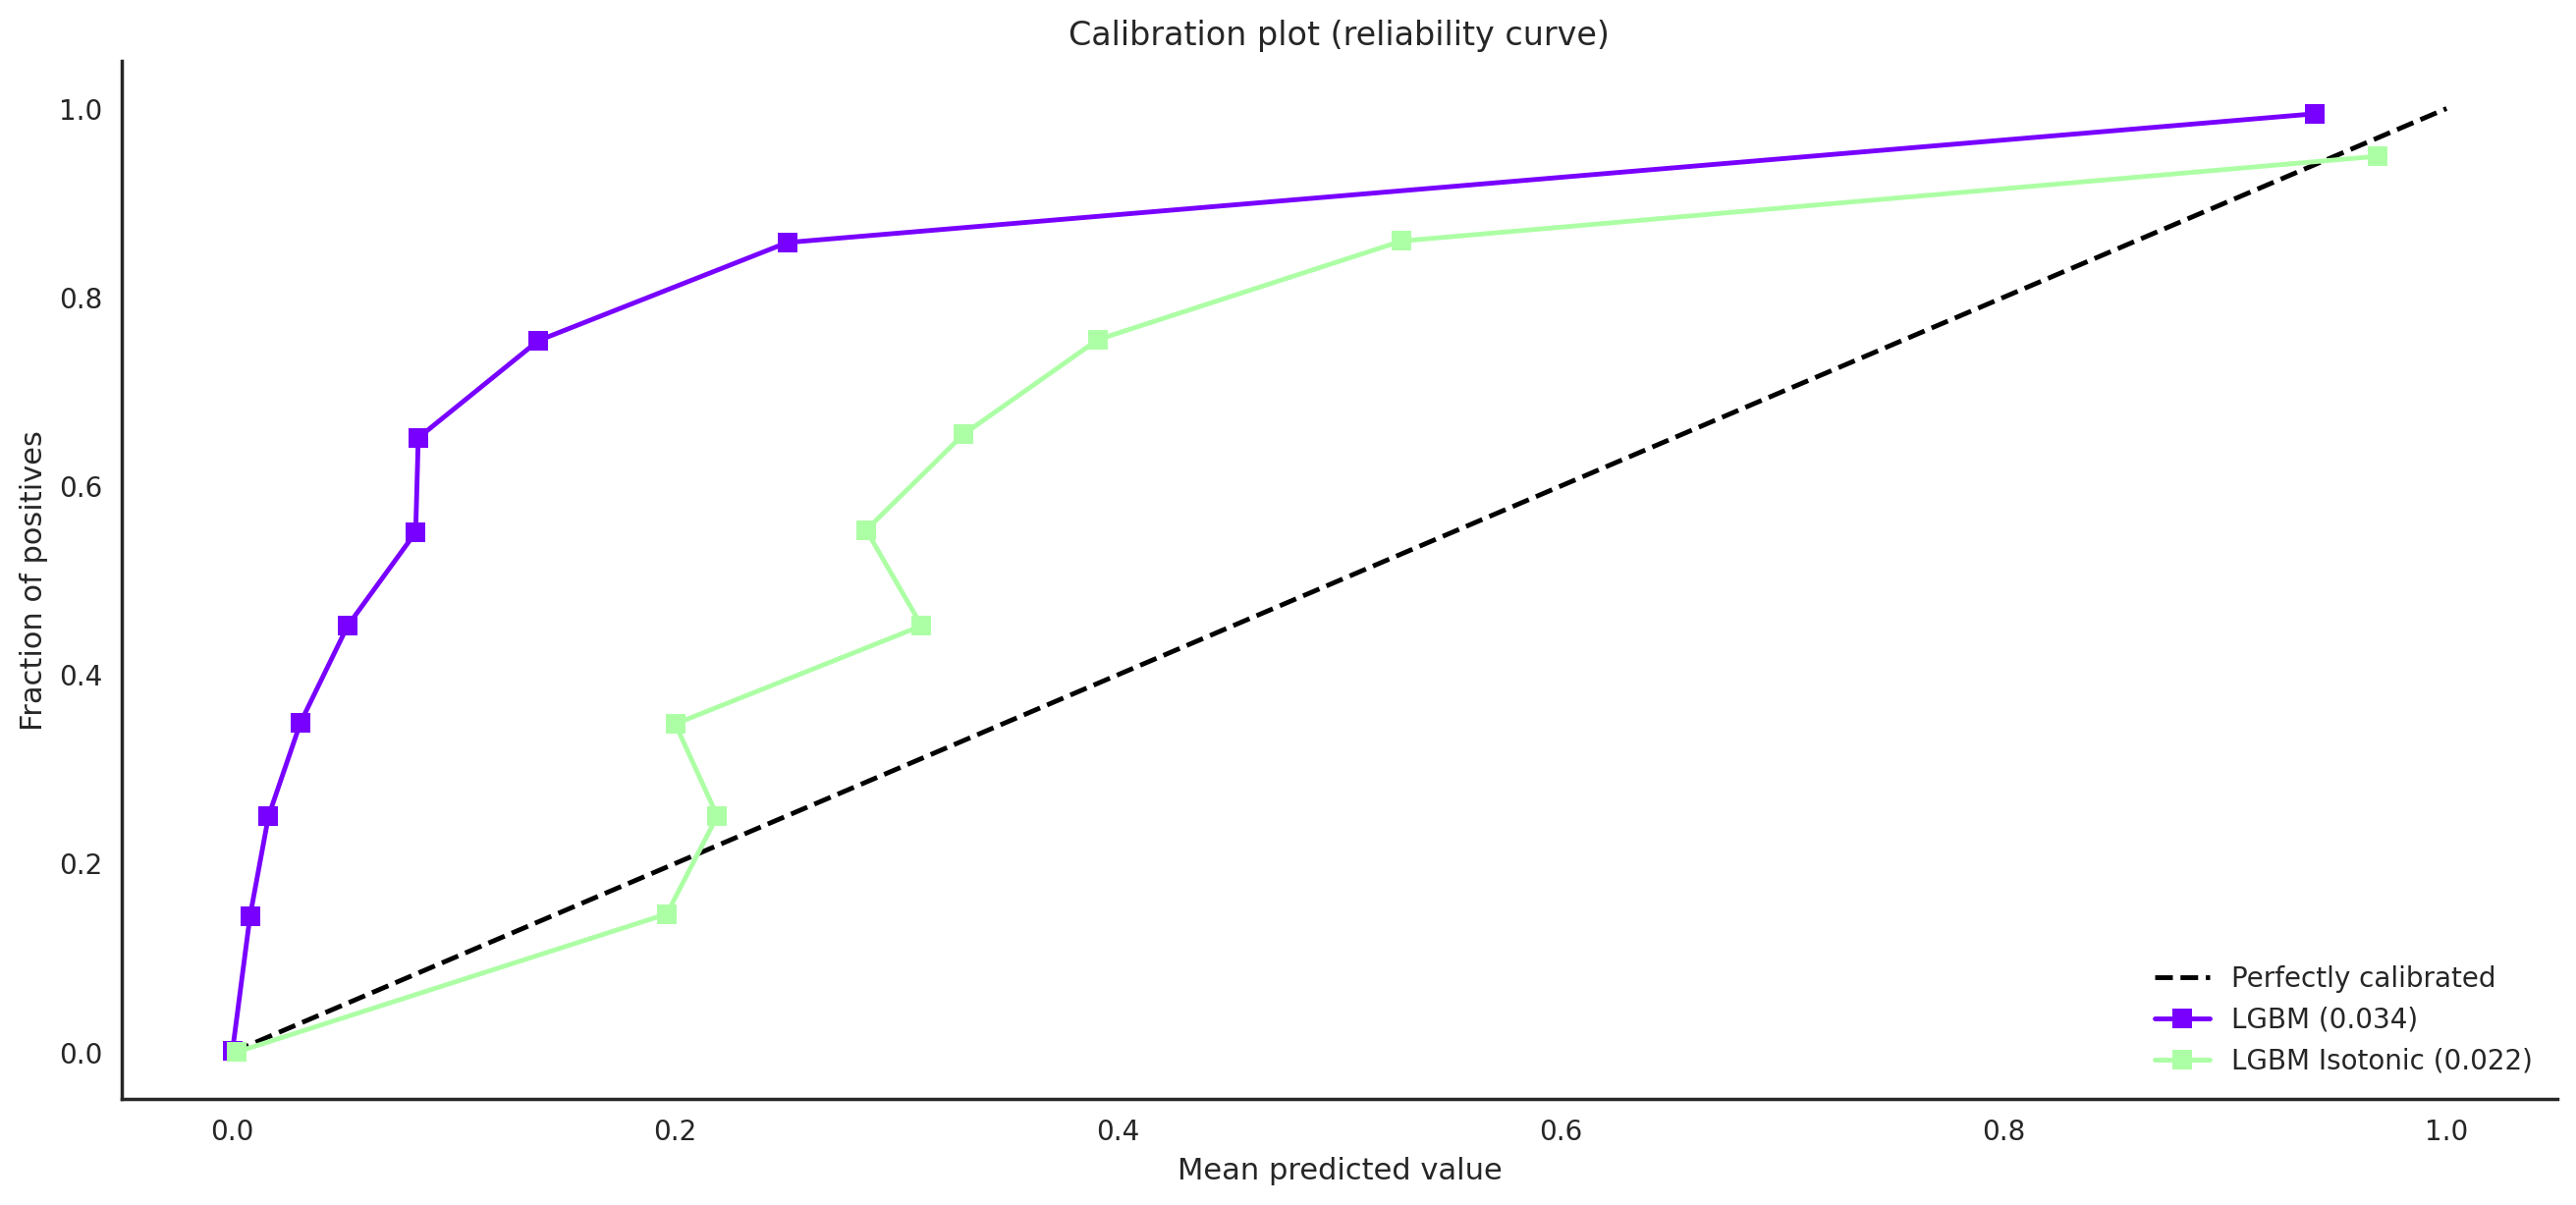

In [ ]:
sns.set_style("ticks")
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated", color="#000000")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title("Calibration plot (reliability curve)")


mpv, fp, score = get_calibration_curve_values(
    lgbm_loans, X_train, y_train, X_test, y_test
)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ("LGBM", score), color="#7800FF")

calibrator_isotonic = CalibratedClassifierCV(lgbm_loans, cv="prefit", method="isotonic")
mpv, fp, score = get_calibration_curve_values(
    calibrator_sigmoid, X_valid, y_valid, X_test, y_test
)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ("LGBM Isotonic", score), color="#ADFFA5")

ax.legend(loc="lower right")
sns.despine()
plt.show()

* After callibration **Brier score** improved. (It is a single specific number that we can refer to, to assess how good our model is. It is a loss score so the smaller it is, the more calibrated the model.)
* Also, the **F1** score improved from 0.94 to 0.96


### 2.1.8 Baseline neural network

I will build a baseline neural network using the torch in this part. It will not be complicated and will not be used during deployment. The main purpose of this part is to compare the results between the improved forest model and the basic neural network.

In [ ]:
numeric_features = [
    "loan_amnt",
    "fico_range",
    "dti",
    "issue_year",
    "sin_mnths",
    "cos_mnths",
]
onehot_features = ["purpose", "emp_length"]
outputs = ["status"]

In [ ]:
categorical_data = cat_to_torch(merged_df)

In [ ]:
numerical_data = np.stack([merged_df[col].values for col in numeric_features], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

In [ ]:
foo = TorchStandardScaler()
foo.fit(numerical_data)
numerical_data = foo.transform(numerical_data)

In [ ]:
outputs = torch.tensor(merged_df[outputs].values).flatten()

In [ ]:
categorical_column_sizes = [
    len(merged_df[column].cat.categories) for column in onehot_features
]
categorical_embedding_sizes = [
    (col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_column_sizes
]

In [ ]:
(
    categorical_train_data,
    categorical_test_data,
    numerical_train_data,
    numerical_test_data,
    train_outputs,
    test_outputs,
) = test_data(categorical_data, numerical_data, outputs)

In [ ]:
model = Model(
    categorical_embedding_sizes, numerical_data.shape[1], 2, [200, 100, 50], p=0.4
)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 150
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss.item())

    if i % 25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")

epoch:   1 loss: 0.82360560
epoch:  26 loss: 0.27856997
epoch:  51 loss: 0.22673297
epoch:  76 loss: 0.19909516
epoch: 101 loss: 0.17851079
epoch: 126 loss: 0.16198544
epoch: 150 loss: 0.1489388198


In [ ]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f"Loss: {loss:.8f}")

Loss: 0.14957999


* From the results of training and tests, we see that there is no overfitting or underfitting
* In addition, our loss function is quite small, which is also a good indicator

In [ ]:
y_val = np.argmax(y_val, axis=1)

In [ ]:
print(classification_report(test_outputs, y_val))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97    400174
           1       0.91      0.91      0.91    157761

    accuracy                           0.95    557935
   macro avg       0.94      0.94      0.94    557935
weighted avg       0.95      0.95      0.95    557935



* Compared to the XGB model, we have achieved better results in all aspects, however, compared to the LGBM model, there is still room for improvement.

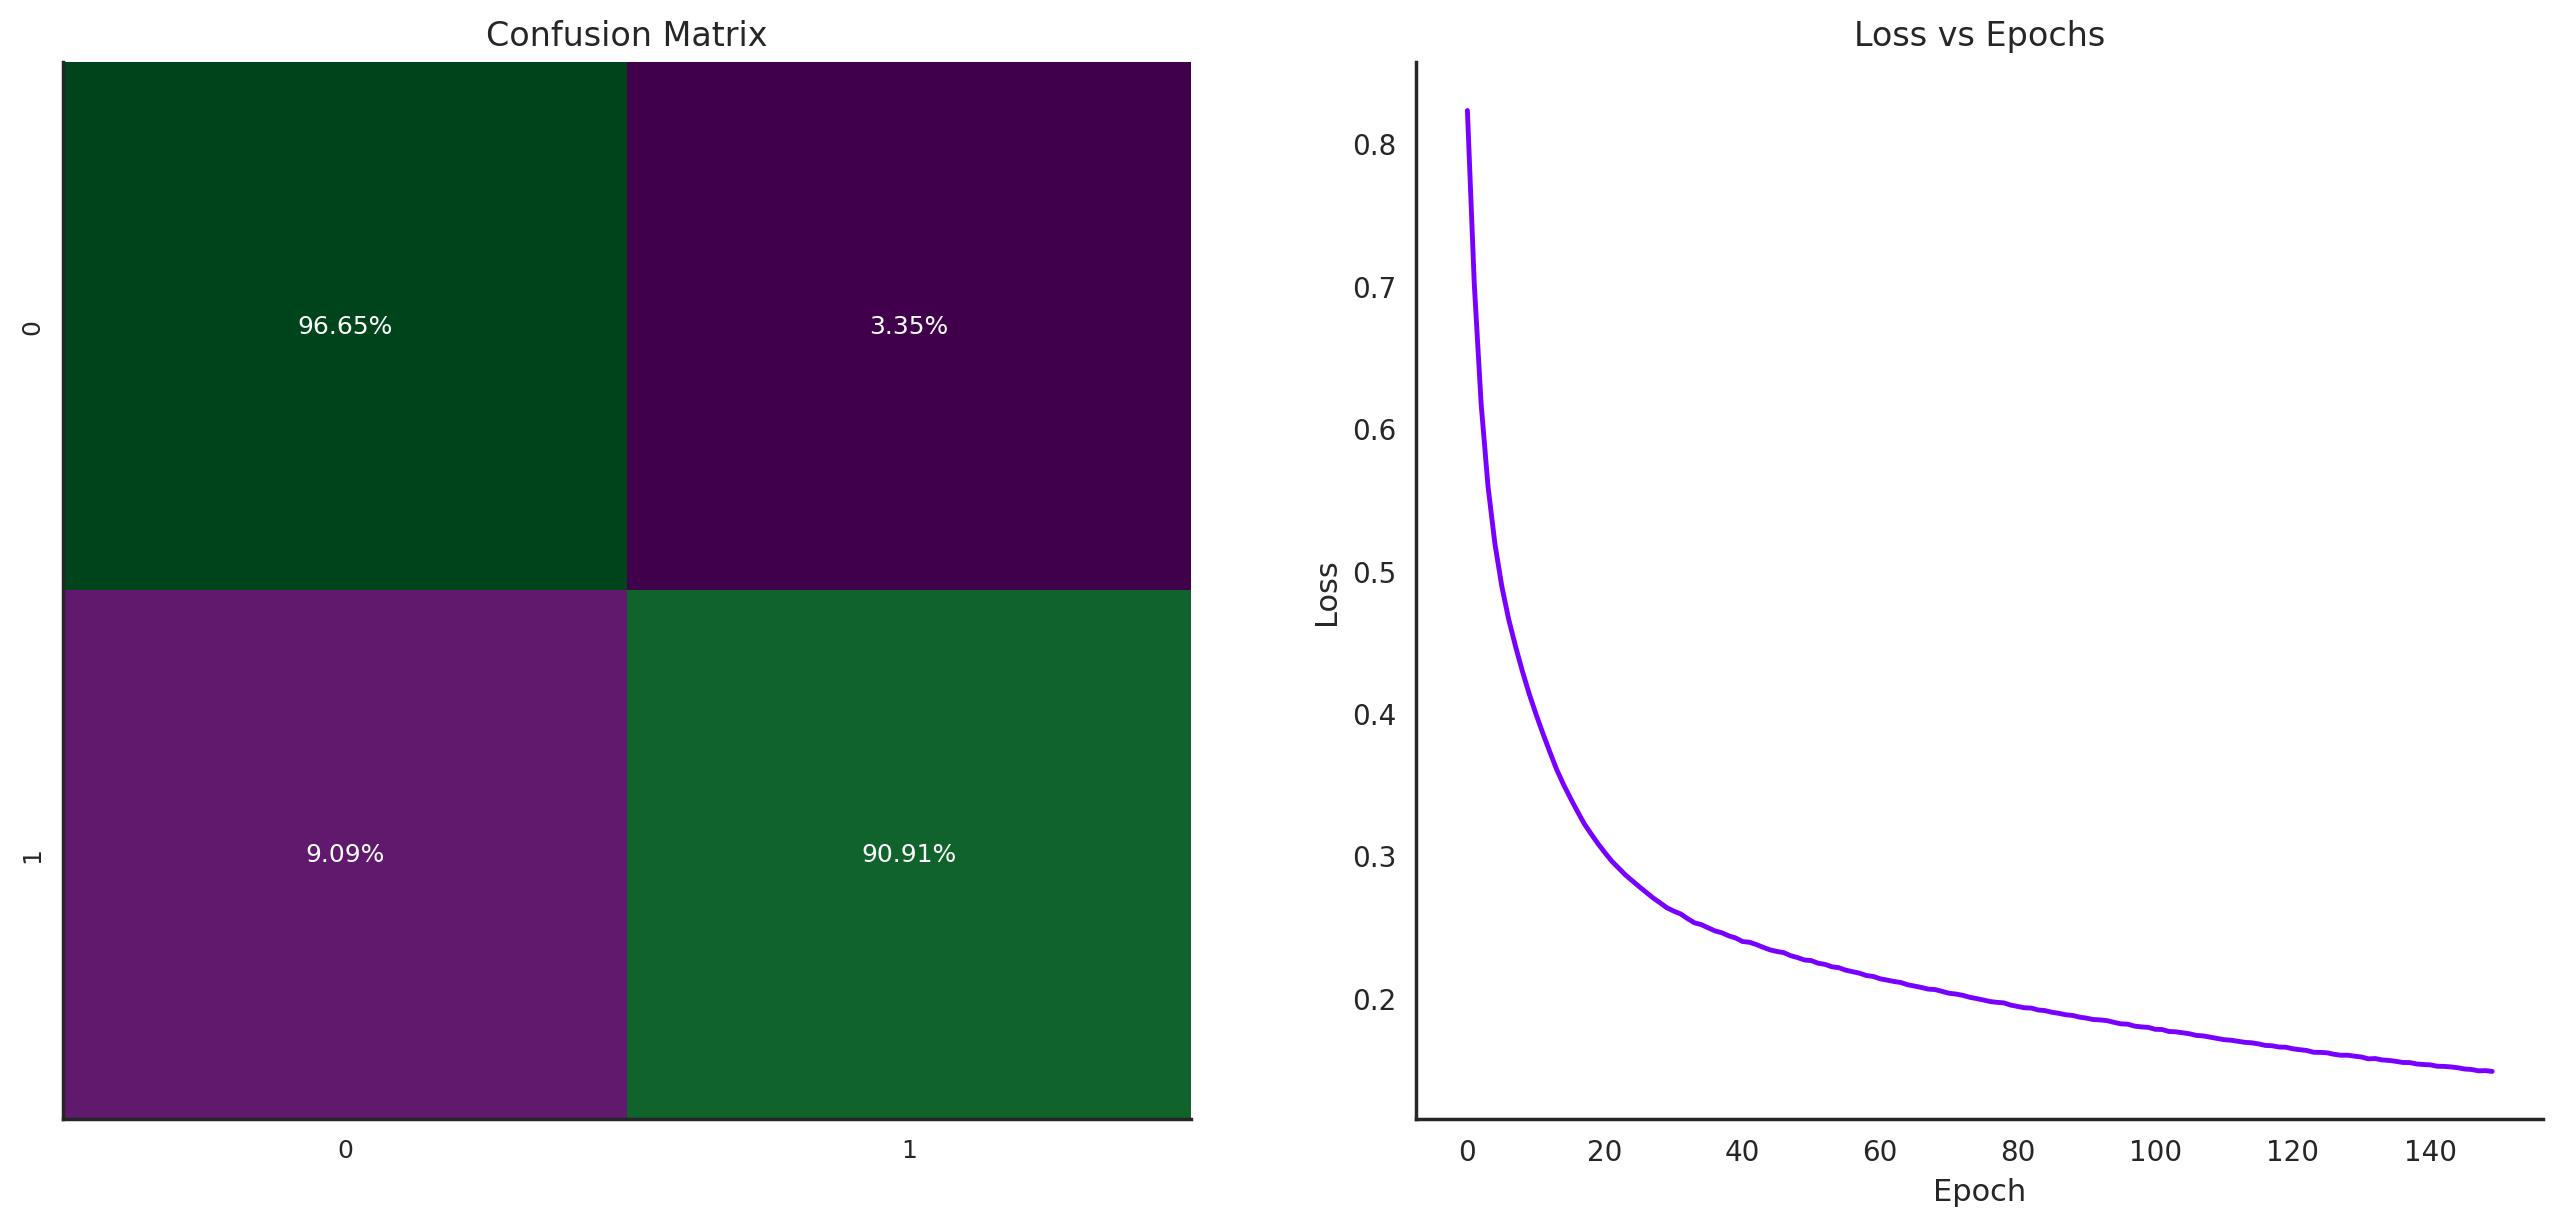

In [ ]:
neural_conf_matrix(
    test_outputs, y_val, aggregated_losses, epochs, "Confusion Matrix", "Loss vs Epochs"
)

* There are more false positive and true negative results compared to other models. But we have to take into account that the data is not normalized and  unbalanced
* We see that the losses decrease rapidly until it have reached 130 epochs. We can also increase the number of epochs to achieve even smaller losses
* We can assume that the implementation of neural networks will not provide a better result compared to a typical forest model. We need to implement parameter tuning for the neural network to try to get the best results. Thus, neural networks are not always the best solution

## 2.2 Predicting grade and sub-grade

In this part we will try to predict **Grade** and **Sub-grade**. As we have already found out in EDA, these two functions have a very strong correlation, so both models will be created in the same section.

In [ ]:
accepted_loan_df = (
    accepted_loan_df.pipe(transformation_mnths, "issue_month")
    .pipe(transformation_mnths, "last_credit_month")
    .pipe(
        drop_columns,
        ["Unnamed: 0", "status", "int_rate", "last_fico_range", "sub_grade"],
    )
    .pipe(drop_spec, ["emp_length"])
)
accepted_loan_df = accepted_loan_df[accepted_loan_df.purpose != "educational"]

In [ ]:
X = accepted_loan_df.drop(columns=["grade"])
y = accepted_loan_df["grade"]

### 2.2.1 Feature selection

There are more than 56 features in our dataset, and that's a lot for our application. I would like to keep as many features as necessary, but we also don't want to overload the user. For this task, I will create an RFECV graph that will provide us with a  score and the number of features. This will help us determine how many features we should keep.

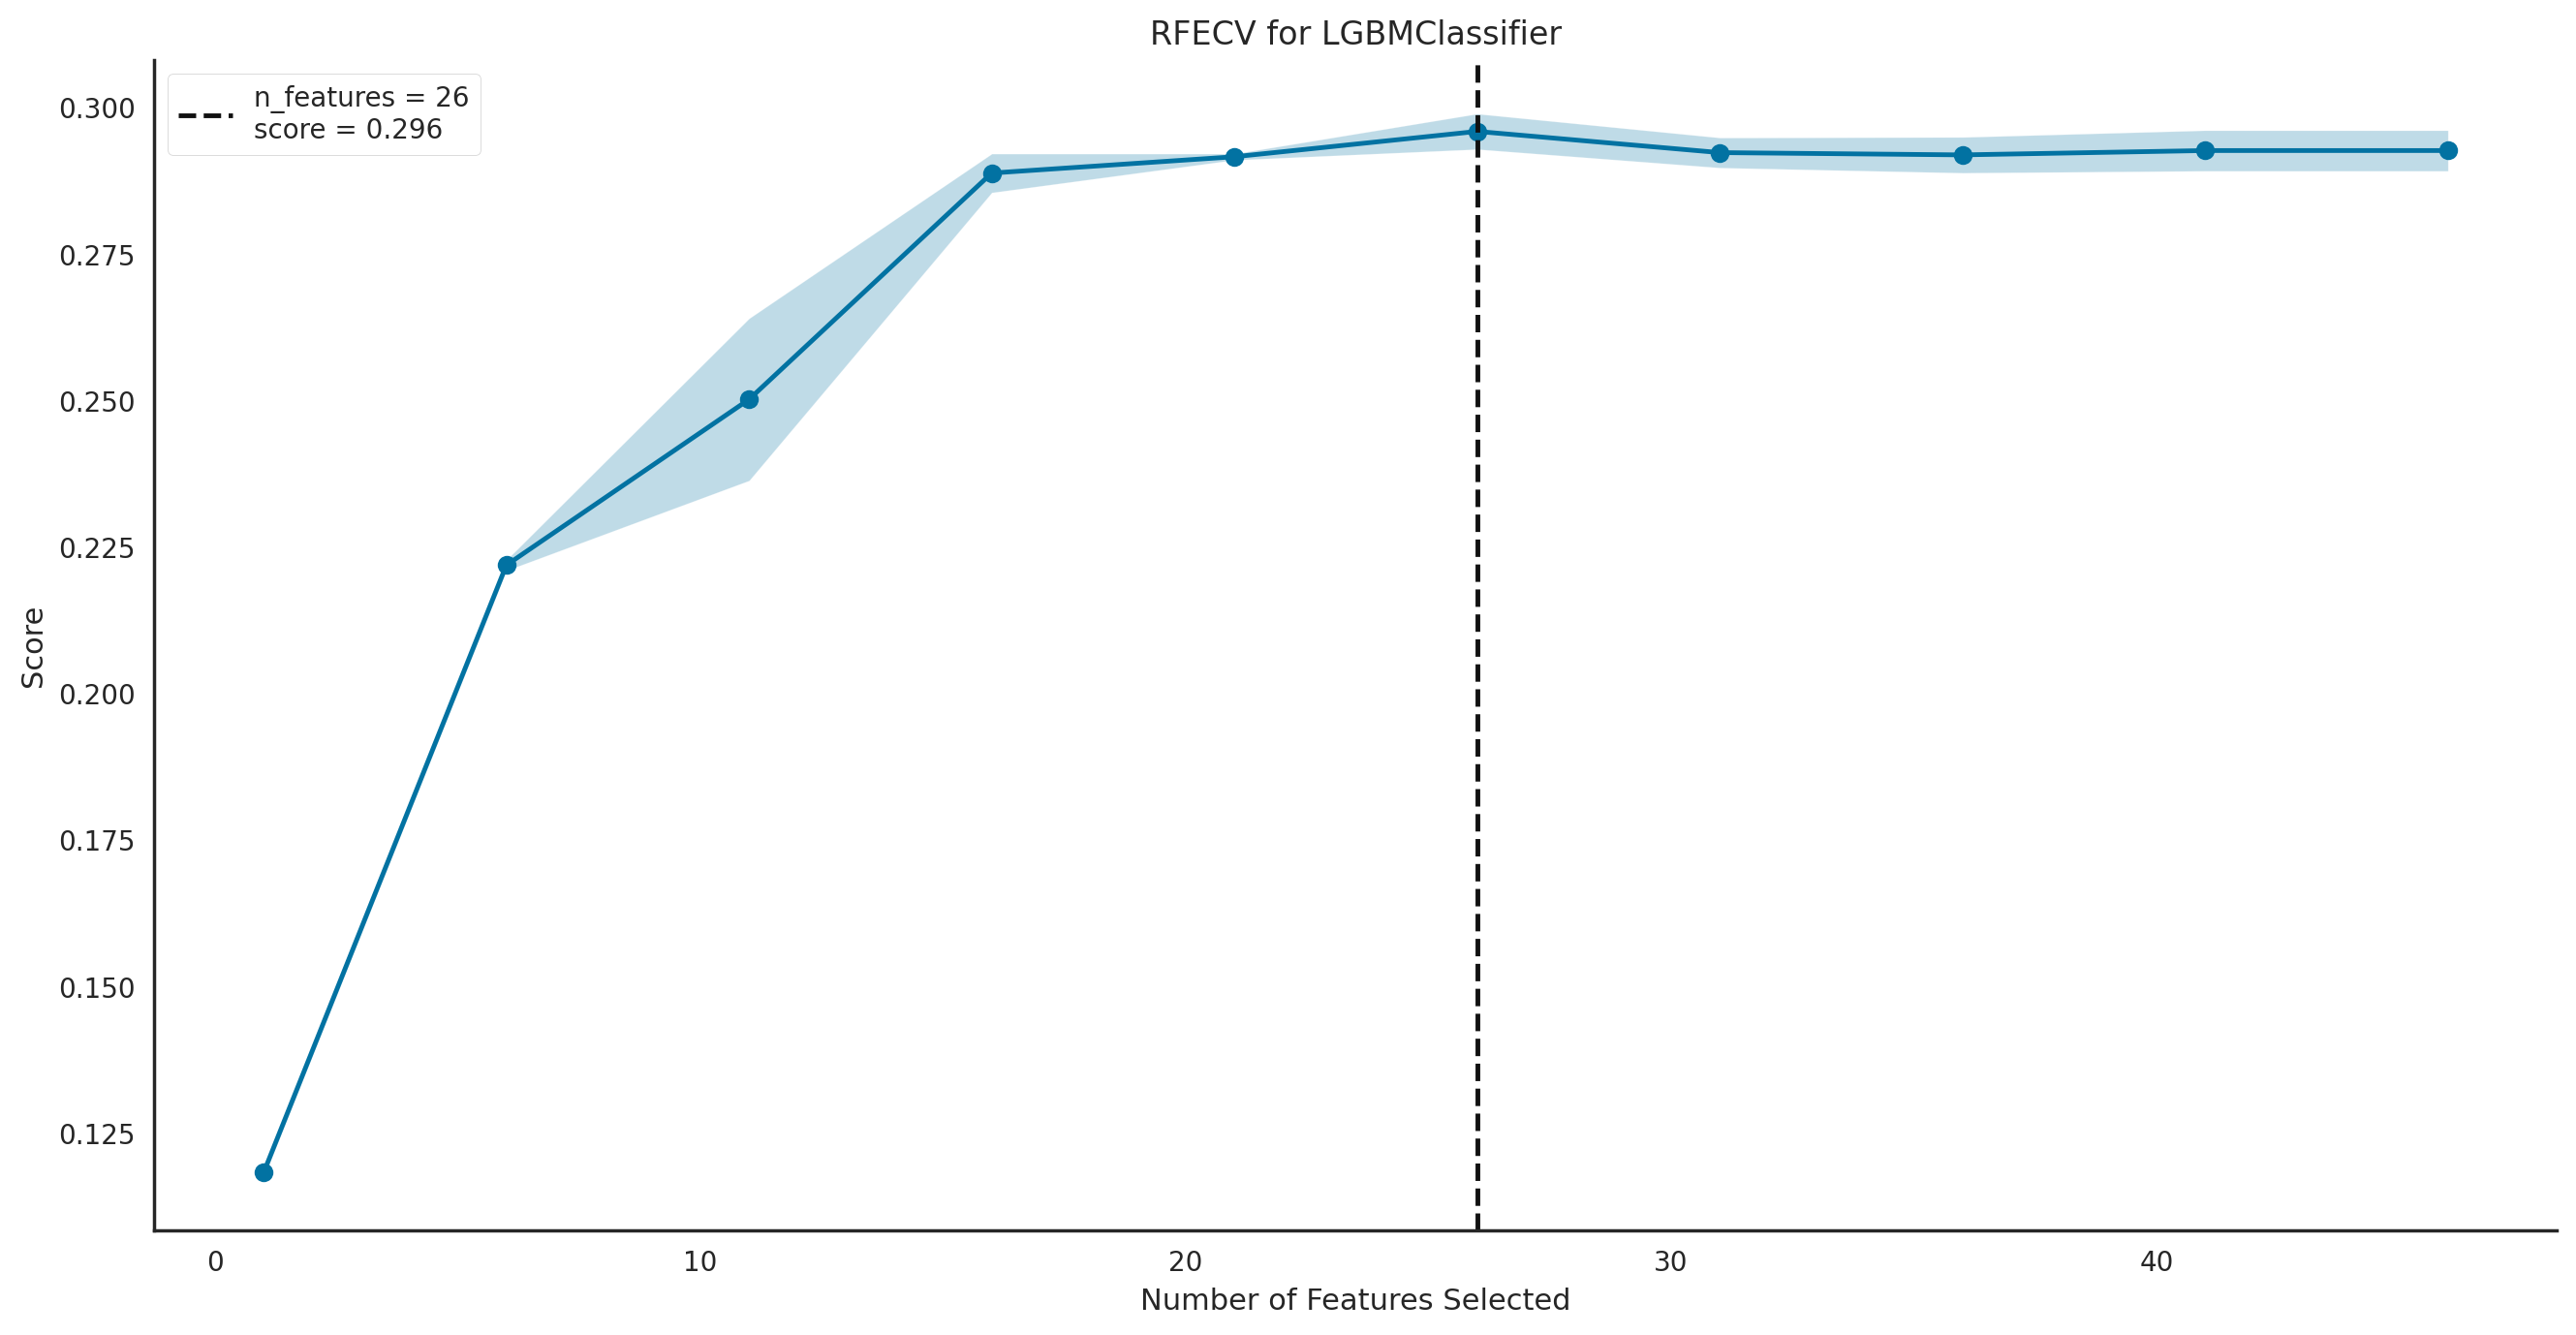

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(16, 8))
visualizer = RFECV(LGBMClassifier(), step=5, cv=3, scoring="f1_macro", color="#7800FF")

visualizer.fit(X, y)
sns.despine()
visualizer.show()
None

* The best result was achieved with 26 featurs, however, we must keep in mind that we have 7 additional categorical featurs, so to maintain the balance, a number of 20 featurs was chosen.

In [ ]:
rfecv = RFECV(
    estimator=LGBMClassifier(),
    min_features_to_select=20,
    step=5,
    n_jobs=-1,
    scoring="f1_macro",
    cv=5,
)

_ = rfecv.fit(X, y)

col_to_keep = X.columns[rfecv.support_]

* Lastly we found all the labels of those 20 features

### 2.2.2 Grade baseline models

First, we check the baseline models when we proceed to setting up the hyperparameters of the selected model

In [ ]:
numeric_features = list(col_to_keep)
onehot_features = [
    "purpose",
    "emp_length",
    "emp_title",
    "home_ownership",
    "application_type",
    "hardship_status",
]
binary_features = ["addr_state"]

In [ ]:
cl_to_keep = numeric_features + onehot_features + binary_features
X = X[cl_to_keep]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.3, random_state=42
)

In [ ]:
onehot_transformer = Pipeline(
    steps=[("onehot_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer = Pipeline(
    steps=[("binary_encoder", ce.BinaryEncoder(cols=binary_features))]
)

numeric_transformer = Pipeline(steps=[("numeric_transforner", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", onehot_transformer, onehot_features),
        ("binary", binary_transformer, binary_features),
        ("numeric_transforner", numeric_transformer, numeric_features),
    ]
)
final_pipeline = Pipeline([("preprocessor", preprocessor)])

In [ ]:
base_df = base_line_multi(X_train, y_train, preprocessor)
base_df

,Balanced accuracy,Accuracy,Recall,Precision,f1,Fit_time
XGB classifier,0.264569,0.499679,0.264569,0.339725,0.249829,225.659626
Logistic regression,0.269470,0.497880,0.269470,0.344067,0.262220,19.306512
LGBM classifier,0.293262,0.517524,0.293262,0.376743,0.295068,37.532134


* The worst performance was demonstrated by the XGB model, in addition to the worst fitting time, it has worse metrics compared to logistic regression
* Best results have LGBM except fitting time
* Since we have very poor results, I choose only LGBM for hyperparameter tuning because it has really relativly good results compared to others

### 2.2.3 LGBM for grade predicting HP tuning

In [ ]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: LGBM_objective_multi(trial, X_train, y_train, final_pipeline)
study.optimize(func, n_trials=50, show_progress_bar=True)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
lgbm_grade = Pipeline(
    steps=[
        ("final_pipeline", final_pipeline),
        (
            "classifier",
            LGBMClassifier(
                **lgbm_params,
                objective="multiclass",
                class_weight="balanced",
                verbose=-1
            ),
        ),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, lgbm_grade.predict(X_test)))

              precision    recall  f1-score   support

           A       0.65      0.76      0.70    130243
           B       0.51      0.46      0.49    169381
           C       0.48      0.29      0.36    157408
           D       0.28      0.29      0.28     67653
           E       0.13      0.28      0.18     21221
           F       0.07      0.39      0.11      5034
           G       0.04      0.26      0.07      1624

    accuracy                           0.45    552564
   macro avg       0.31      0.39      0.31    552564
weighted avg       0.49      0.45      0.46    552564



* We can see that the best f1 result was achieved by the grades with the largest number of samples, and as we approached the lower grades, the score decreased rapidly
* I tried to implement various sampling methods: SMOTE, SMOTomlinks, etc., but the results did not improve much.

In [ ]:
# filename = 'grade_lgbm.sav'
# joblib.dump(lgbm_grade, filename)

['grade_lgbm.sav']

### 2.2.4 Grade model feature importance

In [ ]:
feature_names = list(get_feature_names(preprocessor))

Transformer numeric_transforner (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [ ]:
X_test_grade = lgbm_grade[:-1].transform(X_test)
explainer = shap.TreeExplainer(lgbm_grade[-1])
shap_values = explainer.shap_values(X_test_grade)

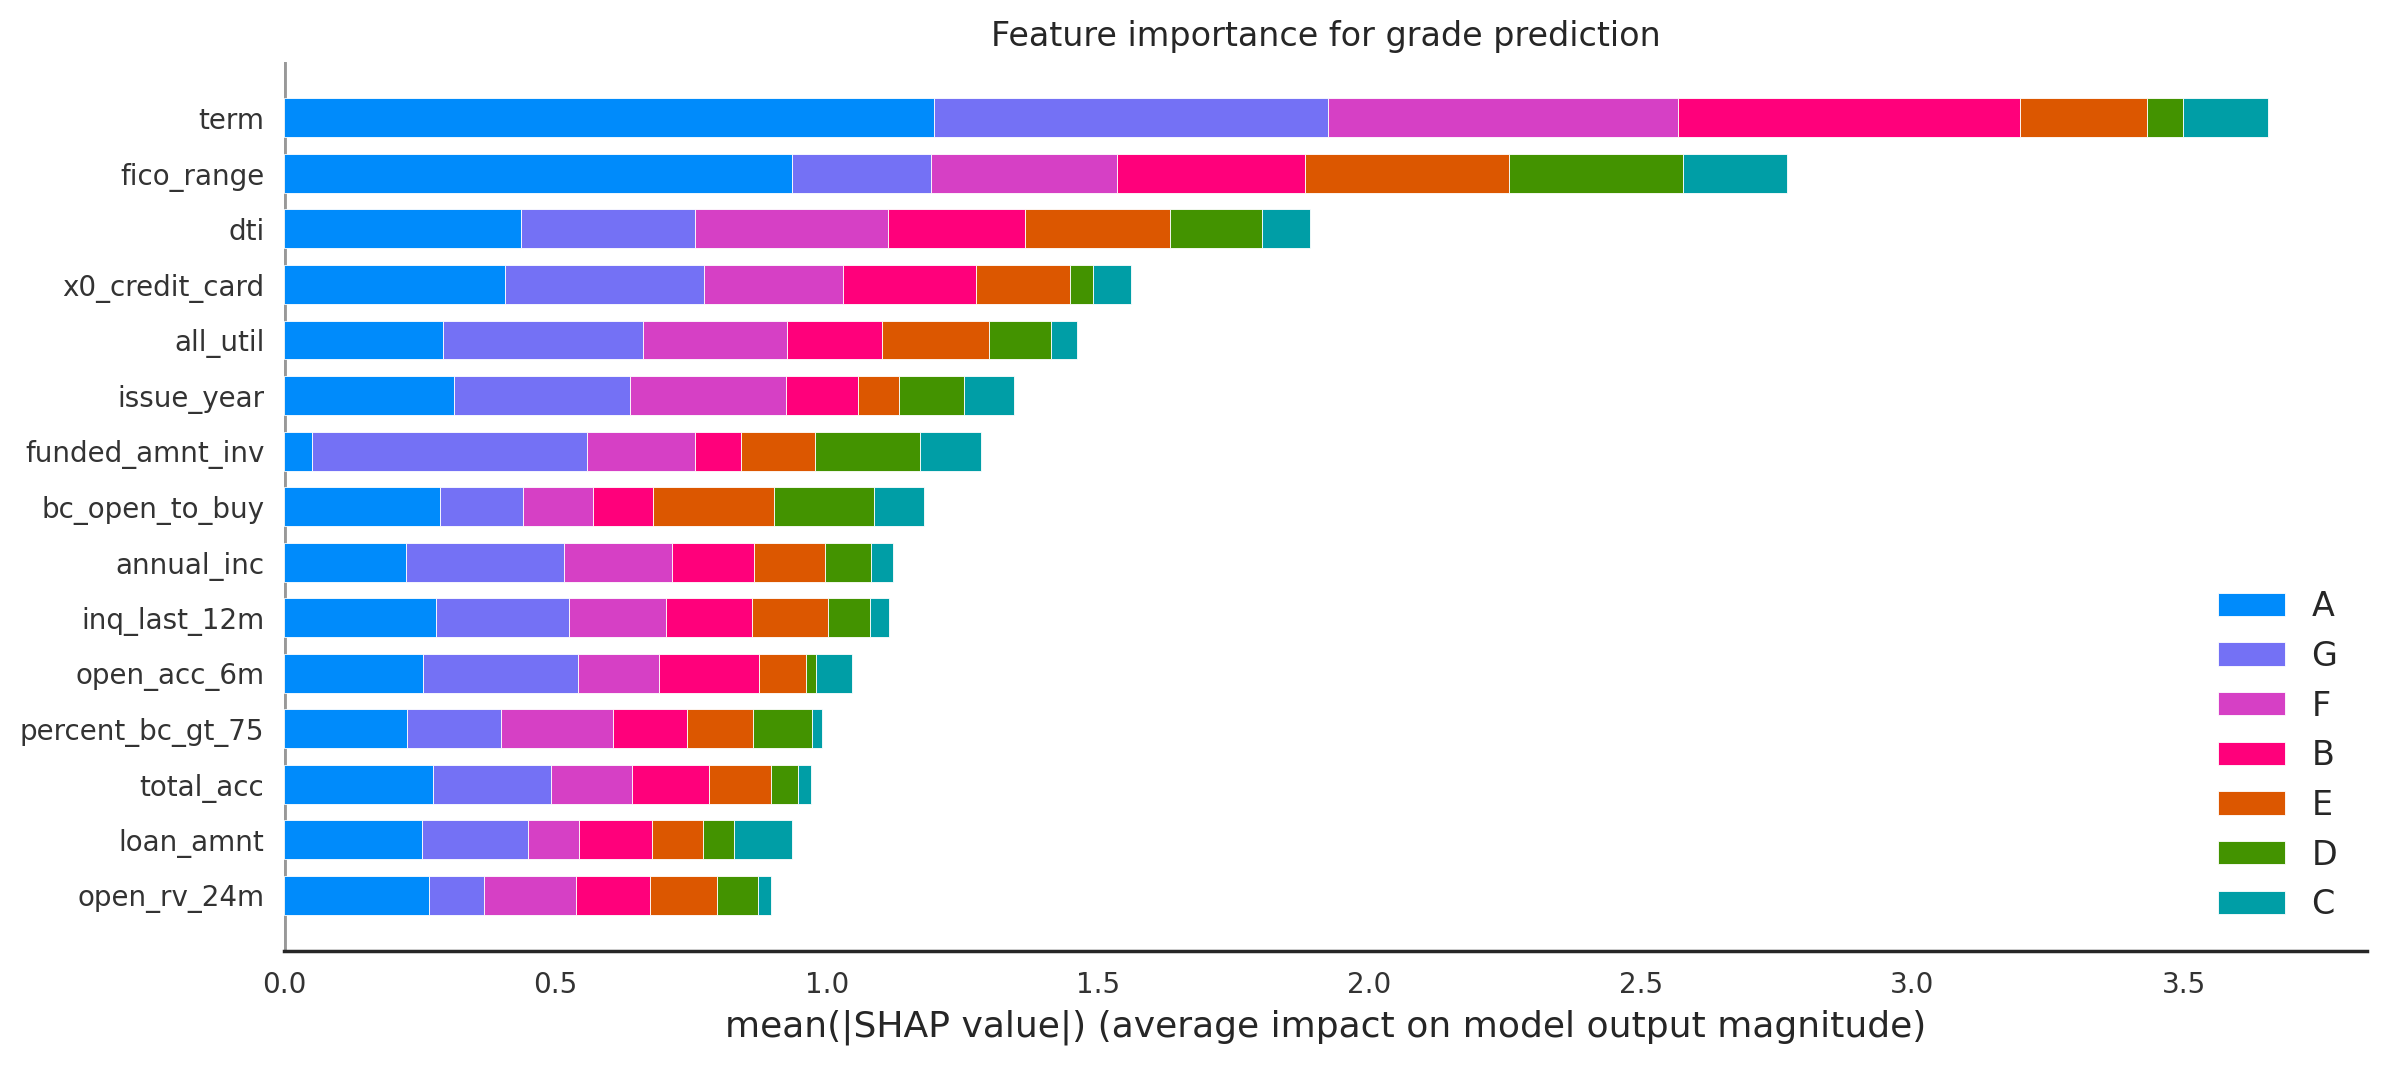

In [ ]:
shap.summary_plot(
    shap_values,
    X_test_grade,
    feature_names=feature_names,
    max_display=15,
    show=False,
    class_names=["A", "B", "C", "D", "E", "F", "G"],
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 5)
ax.set_title("Feature importance for grade prediction", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

* **Term** have bigest impact on grades: A, G, F and B. This is due to the fact that most A classes have a term of 36 months, while G and F have 60 months.
* Grades C, D, E mostly impacted by fico range
* Most important features overal are:
  
  * Term
  * Fico range
  * dti
  * Reason for loan 'Credit card' 

### 2.2.5 Sub-grade prediction with LGBM

In this subsection I will predict the sub-grades. Part of the features selection and parts of the baseline models will be skipped, since there is no significant difference compared to the subsection **Grade prediction**

In [ ]:
accepted_loan_df = (
    accepted_loan_df.pipe(transformation_mnths, "issue_month")
    .pipe(transformation_mnths, "last_credit_month")
    .pipe(drop_columns, ["Unnamed: 0", "status", "int_rate", "last_fico_range"])
    .pipe(drop_spec, ["emp_length"])
)
accepted_loan_df = accepted_loan_df[accepted_loan_df.purpose != "educational"]

In [ ]:
numeric_features = list(col_to_keep)
onehot_features = [
    "purpose",
    "emp_length",
    "emp_title",
    "home_ownership",
    "application_type",
    "hardship_status",
]
binary_features = ["addr_state"]
grades = ["grade", "sub_grade"]

In [ ]:
cl_to_keep = numeric_features + onehot_features + binary_features + grades
accepted_grade = accepted_loan_df[cl_to_keep]

In [ ]:
subgrade_ml_eval = pd.DataFrame(columns=["Grade", "F1-score", "Precision", "Recall"])

for grade in ["A", "B", "C", "D", "E", "F", "G"]:

    print(f"Starting training for grade {grade}:")
    result = train_lgbm_subgrade(grade, accepted_grade, final_pipeline)
    print(f"Best F1-score on training set:", str(round(result[0], 3)))
    if grade == "A":
        lgbm_hp = result[1]
    subgrade_ml_eval = pd.concat(
        [
            subgrade_ml_eval,
            pd.DataFrame(
                data=result[2], index=[str(grade) + "1 - " + str(grade) + "5"]
            ),
        ]
    )

In [ ]:
subgrade_ml_eval = subgrade_ml_eval.drop(columns=["Grade"])
subgrade_ml_eval.round(3)

,F1-score,Precision,Recall
A1 - A5,0.347,0.351,0.357
B1 - B5,0.270,0.274,0.284
C1 - C5,0.241,0.245,0.254
D1 - D5,0.232,0.245,0.252
E1 - E5,0.281,0.290,0.300
F1 - F5,0.235,0.237,0.240
G1 - G5,0.065,0.039,0.200


* We have similar situation to Grade prediction. Sub-grades with smaller sample sizes have worst results. Also overall results became worse.

In [ ]:
accepted_grade = accepted_grade[accepted_grade["grade"] == "A"]
y = accepted_grade["sub_grade"]
X = accepted_grade.drop(["sub_grade", "grade"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [ ]:
lgbm_subgrade = Pipeline(
    steps=[
        ("preprocessor", final_pipeline),
        (
            "classifier",
            LGBMClassifier(
                objective="multiclass",
                class_weight="balanced",
                **lgbm_hp,
                random_state=42,
            ),
        ),
    ]
).fit(X_train, y_train)

In [ ]:
# filename = 'sub_grade_lgbm.sav'
# joblib.dump(lgbm_subgrade, filename)

['sub_grade_lgbm.sav']

In [ ]:
subgrade_pred = lgbm_subgrade.predict(X_test)

In [ ]:
print(
    "\033[1m" + "Classification report for test set with LightGBM:\n\n" + "\033[0m",
    classification_report(
        y_test, accepted_grade, target_names=["A1", "A2", "A3", "A4", "A5"]
    ),
)

Classification report for test set with LightGBM:

               precision    recall  f1-score   support

          A1       0.48      0.54      0.51      8161
          A2       0.27      0.30      0.28      6290
          A3       0.26      0.21      0.23      6638
          A4       0.37      0.21      0.27      8027
          A5       0.39      0.53      0.45      8191

    accuracy                           0.37     37307
   macro avg       0.35      0.36      0.35     37307
weighted avg       0.36      0.37      0.36     37307



* The values between A1 and A5 are much smaller, so the overall result we saw above is also smaller

### 2.2.6 Sub-grade model feature importance

In [ ]:
feature_names = list(get_feature_names(preprocessor))

Transformer numeric_transforner (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [ ]:
X_test_sub = final_pipeline.transform(X_test)
explainer = shap.TreeExplainer(lgbm_subgrade[-1])
shap_values = explainer.shap_values(X_test_sub)

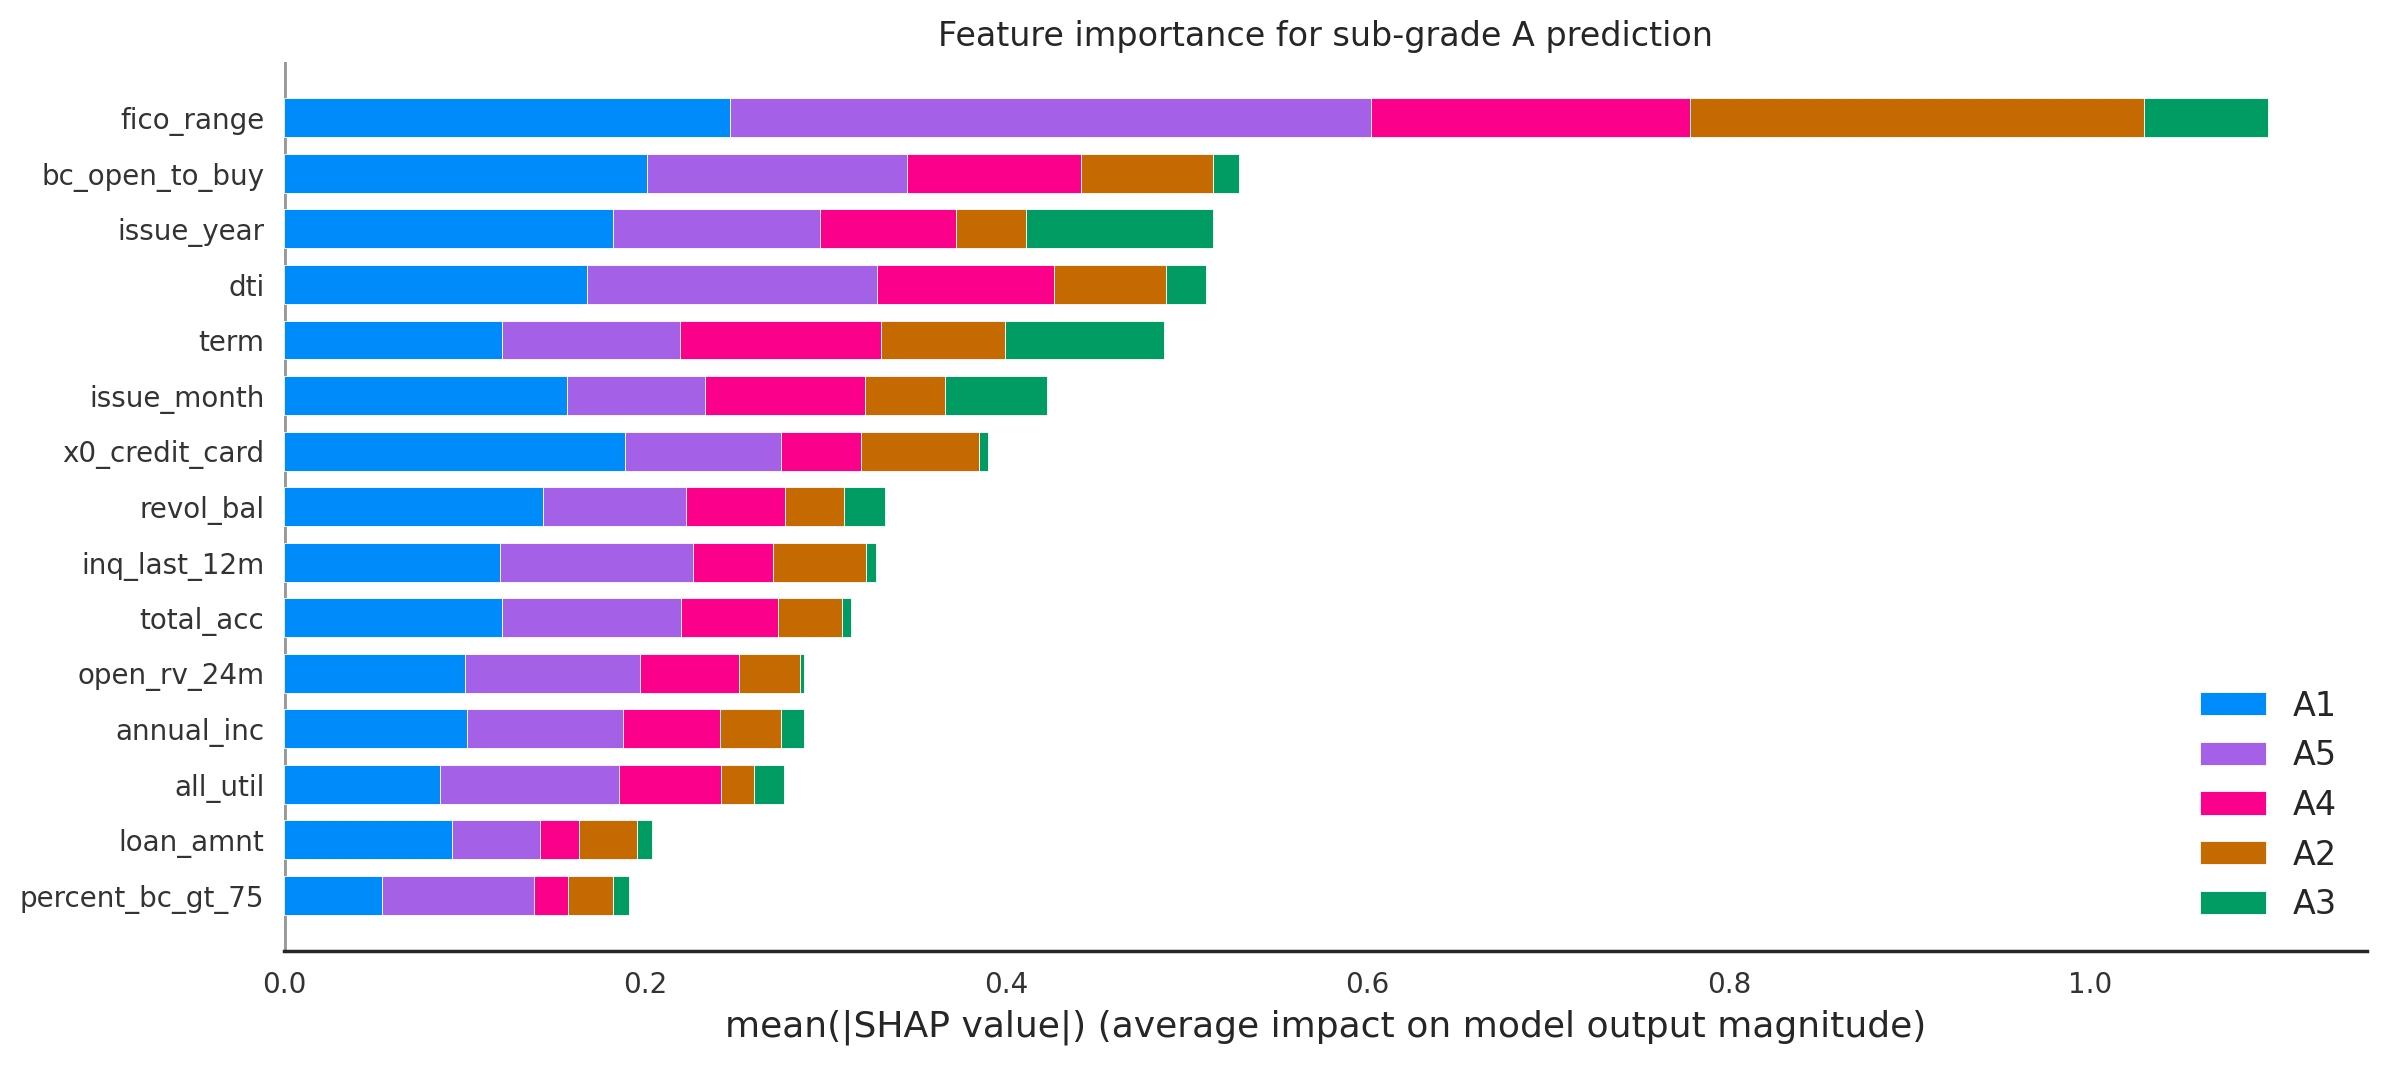

In [ ]:
shap.summary_plot(
    shap_values,
    X_test_sub,
    feature_names=feature_names,
    max_display=15,
    show=False,
    class_names=["A1", "A2", "A3", "A4", "A5"],
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 5)
ax.set_title("Feature importance for sub-grade A prediction", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

5 most important features:

* fico_range
* bc open to buy
* issue_year
* dti
* term

We can see that the importance of the features has changed slightly compared to the importance of the **Grade** model features.

# 3 Conclusion

* Classification of loan acceptance:
  
  * In general, each model showed excellent results, with the exception of logistic regression
  * Hyperparameters of XGB and LGBM were tuned as they had descent results and fitting time however for deployment LGBM model was choosen as it had highes F1 scorre equal to 94
  * After calibrating the probability, we achieved an even better result of F1 scorre
  * We compared the underlying neural network and found out that it performs worse than LGBM, and we can assume that NN is not always the answer
  * We have found the most important features for this model

* Grade prediction:

  * Values with more samples had better results
  * Overall we received quite poor results, it may indicate that model can't clearly identify differences between grades
  * We found the  most important features for our prediction

* Sub-grade prediction

  * It have worst result compare to all other models
  * Also difference between values is even smaller so for classifier it is even harder
  * Predictions were made separately for each class, as it returns the most accurate results
  * We can assume that represented data in dataset is not sufficient